In [1]:
# ============================================================
# Libraries
# ============================================================
import pandas as pd
import numpy as np
import datetime

from pyspark.sql.functions import col, sum as spark_sum, when
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna

# ============================================================
# Load & Filter Delta Table
# ============================================================
df = spark.read.format("delta").load("Tables/silver_napcs_ontario_us_trade_by_province_data")

# Add standardized trade type column
df = df.withColumn(
    "Trade_Type_Standardized",
    when(col("Trade_Type") == "Import", "Import")
    .when(col("Trade_Type").isin("Domestic export", "Re-export"), "Export")
    .otherwise(None)
)

# Filter out unwanted data
filtered_df = df.filter(
    (col("Region") == "Ontario") &
    (~col("NAPCS_Commodity_Description").isin(["Special transactions trade", "Total of all merchandise"])) &
    (col("Trade_Type_Standardized").isNotNull())
)

# Use Trade_Type_Standardized for filtering
export_df = filtered_df.filter(col("Trade_Type_Standardized") == "Export")
import_df = filtered_df.filter(col("Trade_Type_Standardized") == "Import")

# ============================================================
# Aggregation
# ============================================================
def aggregate_trade(trade_df):
    return (
        trade_df.groupBy("Year", "Month_Name", "NAPCS_Commodity_Description")
        .agg(spark_sum("Value_Millions").alias("Total_Value_Millions"))
        .toPandas()
    )

export_pd = aggregate_trade(export_df)
import_pd = aggregate_trade(import_df)

if export_pd.empty and import_pd.empty:
    raise ValueError("No data available after filtering/aggregation.")

# ============================================================
# Calendar Features
# ============================================================
month_order = ["January","February","March","April","May","June",
               "July","August","September","October","November","December"]
month_to_num = {m: i+1 for i, m in enumerate(month_order)}
num_to_month = {v: k for k, v in month_to_num.items()}

def add_calendar(pdf):
    pdf = pdf.copy()
    pdf["Month_Num"] = pdf["Month_Name"].map(month_to_num)
    pdf["ym"] = pdf["Year"].astype(int) * 100 + pdf["Month_Num"]
    return pdf.sort_values(["NAPCS_Commodity_Description","ym"]).reset_index(drop=True)

export_pd = add_calendar(export_pd)
import_pd = add_calendar(import_pd)

# ============================================================
# Lag & Rolling Features
# ============================================================
def add_lag_features(pdf):
    pdf = pdf.copy()
    for lag in [1,3,6,12]:
        pdf[f"Lag{lag}"] = pdf.groupby("NAPCS_Commodity_Description")["Total_Value_Millions"].shift(lag)
    pdf["Rolling_Mean_3"] = pdf.groupby("NAPCS_Commodity_Description")["Total_Value_Millions"].transform(
        lambda x: x.rolling(3, min_periods=1).mean().shift(1)
    )
    pdf["Rolling_Mean_12"] = pdf.groupby("NAPCS_Commodity_Description")["Total_Value_Millions"].transform(
        lambda x: x.rolling(12, min_periods=1).mean().shift(1)
    )
    return pdf.dropna().reset_index(drop=True)

export_pd = add_lag_features(export_pd)
import_pd = add_lag_features(import_pd)

# ============================================================
# Metrics Functions
# ============================================================
def safe_mape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
        "MAPE": safe_mape(y_true, y_pred)
    }

# ============================================================
# Time-based Hold-out Split (last 6 months)
# ============================================================
TEST_HORIZON = 6

def make_time_holdout(pdf, horizon=TEST_HORIZON):
    pdf = pdf.sort_values(["NAPCS_Commodity_Description","ym"])
    cutoff = pdf["ym"].max() - horizon
    train_df = pdf[pdf["ym"] <= cutoff]
    test_df  = pdf[pdf["ym"] > cutoff]
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

# ============================================================
# Optuna Hyperparameter Tuning
# ============================================================
def tune_model(model_name, X, y, n_trials=8):
    tscv = TimeSeriesSplit(n_splits=3)
    def objective(trial):
        if model_name=="RandomForest":
            params = {
                "n_estimators": trial.suggest_int("n_estimators",100,300),
                "max_depth": trial.suggest_int("max_depth",4,10),
                "min_samples_split": trial.suggest_int("min_samples_split",2,8),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf",1,4),
                "random_state":42, "n_jobs":-1
            }
            model = RandomForestRegressor(**params)
        elif model_name=="GradientBoosting":
            params = {
                "n_estimators": trial.suggest_int("n_estimators",100,300),
                "learning_rate": trial.suggest_float("learning_rate",0.01,0.1),
                "max_depth": trial.suggest_int("max_depth",3,6),
                "subsample": trial.suggest_float("subsample",0.6,1.0),
                "random_state":42
            }
            model = GradientBoostingRegressor(**params)
        else:
            params = {
                "n_estimators": trial.suggest_int("n_estimators",100,300),
                "learning_rate": trial.suggest_float("learning_rate",0.01,0.1),
                "max_depth": trial.suggest_int("max_depth",3,8),
                "subsample": trial.suggest_float("subsample",0.6,1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree",0.6,1.0),
                "reg_lambda": trial.suggest_float("reg_lambda",0.1,2.0),
                "reg_alpha": trial.suggest_float("reg_alpha",0.0,2.0),
                "random_state":42, "n_jobs":-1
            }
            model = XGBRegressor(**params)

        scores=[]
        for train_idx, val_idx in tscv.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            model.fit(X_train,y_train)
            preds=model.predict(X_val)
            scores.append(mean_absolute_error(y_val,preds))
        return np.mean(scores)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    print(f"🔧 Best {model_name} params: {study.best_params}")
    return study.best_params

# ============================================================
# Train & Evaluate Pooled Models
# ============================================================
def train_and_evaluate(pdf, label, horizon=TEST_HORIZON):
    train_df, test_df = make_time_holdout(pdf, horizon)

    # One-hot encode (same columns for train/test)
    full_cols = pd.get_dummies(pdf[["Month_Name","NAPCS_Commodity_Description"]]).columns
    def encode(df):
        X = pd.get_dummies(df.drop(columns=["Total_Value_Millions","ym"]),
                           columns=["Month_Name","NAPCS_Commodity_Description"])
        return X.reindex(columns=full_cols, fill_value=0)

    X_train, X_test = encode(train_df), encode(test_df)
    y_train, y_test = train_df["Total_Value_Millions"], test_df["Total_Value_Millions"]

    models, metrics, best_params = {}, {}, {}

    for name in ["RandomForest","GradientBoosting","XGBoost"]:
        best = tune_model(name, X_train, y_train, n_trials=8)
        best_params[name] = best
        if name=="RandomForest":
            model=RandomForestRegressor(**best)
        elif name=="GradientBoosting":
            model=GradientBoostingRegressor(**best)
        else:
            model=XGBRegressor(**best)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        metrics[name] = evaluate(y_test, preds)
        models[name] = model
        print(f"[{label}] {name} hold-out metrics: {metrics[name]}")

    return models, full_cols, metrics, best_params, train_df, test_df

export_models, export_feats, export_metrics, export_best, export_train, export_test = \
    train_and_evaluate(export_pd, "Export")

import_models, import_feats, import_metrics, import_best, import_train, import_test = \
    train_and_evaluate(import_pd, "Import")

# ============================================================
# Iterative Multi-step Forecasting (Fixed)
# ============================================================
latest_ym = max(export_pd["ym"].max(), import_pd["ym"].max())
latest_year, latest_month = latest_ym // 100, latest_ym % 100

def add_months(year, month, k):
    total = year*12 + (month-1) + k
    y = total // 12
    m = total % 12 + 1
    return y, m, num_to_month[m]

future_months = [add_months(latest_year, latest_month, k) for k in range(1,7)]

def iterative_forecast_fixed(df_raw, models_dict, feature_cols, trade_type, metrics_dict):
    df_raw = df_raw.sort_values(["NAPCS_Commodity_Description","ym"])
    state = {c:list(g["Total_Value_Millions"].values) for c,g in df_raw.groupby("NAPCS_Commodity_Description")}
    preds_all = []

    for y,m,mname in future_months:
        rows = []
        for c,hist in state.items():
            rows.append({
                "Year": y,
                "Month_Name": mname,
                "NAPCS_Commodity_Description": c,
                "Lag1": hist[-1] if len(hist)>=1 else np.nan,
                "Lag3": hist[-3] if len(hist)>=3 else hist[-1],
                "Lag6": hist[-6] if len(hist)>=6 else hist[-1],
                "Lag12": hist[-12] if len(hist)>=12 else hist[-1],
                "Rolling_Mean_3": np.mean(hist[-3:]),
                "Rolling_Mean_12": np.mean(hist[-12:])
            })
        
        temp = pd.DataFrame(rows)
        temp_enc = pd.get_dummies(temp, columns=["Month_Name","NAPCS_Commodity_Description"])
        temp_enc = temp_enc.reindex(columns=feature_cols, fill_value=0)

        # Predict
        model_preds = {n:m.predict(temp_enc) for n,m in models_dict.items()}
        ensemble = np.mean(list(model_preds.values()), axis=0)

        for i, c in enumerate(temp["NAPCS_Commodity_Description"]):
            # Individual models
            for n in models_dict:
                row_dict = {
                    "Year": y,
                    "Month_Num": m,
                    "ym": y*100 + m,
                    "NAPCS_Commodity_Description": c,
                    "Trade_Type_Standardized": trade_type,
                    "Row_Type": "Predicted",
                    "Model_Used": n,
                    "Predicted_Value_Millions": float(model_preds[n][i]),
                    "Actual_Value_Millions": np.nan
                }
                for k,v in metrics_dict[n].items():
                    row_dict[k] = float(v)
                preds_all.append(row_dict)

            # Ensemble row
            avg_metrics = {k: float(np.mean([v[k] for v in metrics_dict.values()])) for k in ["MAE","RMSE","R2","MAPE"]}
            row_ens = {
                "Year": y,
                "Month_Num": m,
                "ym": y*100 + m,
                "NAPCS_Commodity_Description": c,
                "Trade_Type_Standardized": trade_type,
                "Row_Type": "Predicted",
                "Model_Used": "Ensemble",
                "Predicted_Value_Millions": float(ensemble[i]),
                "Actual_Value_Millions": np.nan,
                **avg_metrics
            }
            preds_all.append(row_ens)

            # Update history
            state[c].append(ensemble[i])

    return pd.DataFrame(preds_all)

# Fixed import line — now includes import_metrics
export_preds = iterative_forecast_fixed(export_pd, export_models, export_feats, "Export", export_metrics)
import_preds = iterative_forecast_fixed(import_pd, import_models, import_feats, "Import", import_metrics)

# ============================================================
# Combine Actual + Predictions & Save
# ============================================================
def get_last_actual(df_raw, trade_type):
    last = df_raw[df_raw["ym"]==latest_ym].copy()
    last.rename(columns={"Total_Value_Millions":"Actual_Value_Millions"}, inplace=True)
    last["Predicted_Value_Millions"] = np.nan
    last["Trade_Type_Standardized"] = trade_type
    last["Row_Type"] = "Actual"
    last["Model_Used"] = np.nan
    for c in ["MAE","RMSE","R2","MAPE"]: last[c]=np.nan
    return last

combined = pd.concat([
    export_preds, import_preds,
    get_last_actual(export_pd, "Export"),
    get_last_actual(import_pd, "Import")
], ignore_index=True)

cols_order = ["Year","Month_Name","Month_Num","ym","NAPCS_Commodity_Description",
              "Trade_Type_Standardized","Row_Type","Actual_Value_Millions",
              "Predicted_Value_Millions","Model_Used","MAE","RMSE","R2","MAPE"]
for c in cols_order:
    if c not in combined.columns: combined[c]=np.nan

combined = combined[cols_order].copy()
combined["Year"] = combined["Year"].fillna(0).astype(int)
combined["Month_Num"] = combined["Month_Num"].fillna(0).astype(int)
combined["ym"] = combined["ym"].fillna(0).astype(int)
for c in ["Actual_Value_Millions","Predicted_Value_Millions","MAE","RMSE","R2","MAPE"]:
    combined[c] = combined[c].astype(float)

# Safe date
def safe_date(row):
    if row["Year"] > 0 and 1 <= row["Month_Num"] <= 12:
        return datetime.date(int(row["Year"]), int(row["Month_Num"]), 1)
    else:
        return None

combined["date"] = combined.apply(safe_date, axis=1)
combined = combined.sort_values(by=["Trade_Type_Standardized","Row_Type","NAPCS_Commodity_Description","ym"]).reset_index(drop=True)

# Save to Predictive modeling in Gold Lakehouse
combined_spark = spark.createDataFrame(combined)

combined_spark.write \
    .format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .save("abfss://1dcd65a7-d5a3-4e2b-a110-db438703b7b5@onelake.dfs.fabric.microsoft.com/e14547c6-561b-467b-bef2-943e66043393/Tables/gold_predictive_modelling_data")

print("✅ Predictions + metrics + last actual saved to 'Tables/gold_predictive_modelling_data'")


StatementMeta(, b700f20a-7c0f-4d83-9cc9-473aa3b882d2, 3, Finished, Available, Finished)

[I 2025-11-17 19:27:05,415] A new study created in memory with name: no-name-c9499004-9606-4f63-8577-26a4c2e72b34


[I 2025-11-17 19:27:39,747] Trial 0 finished with value: 1059.1681092053116 and parameters: {'n_estimators': 209, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 1059.1681092053116.


[I 2025-11-17 19:27:55,830] Trial 1 finished with value: 1036.5207897100797 and parameters: {'n_estimators': 105, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 1 with value: 1036.5207897100797.


[I 2025-11-17 19:28:13,821] Trial 2 finished with value: 1041.2428113502624 and parameters: {'n_estimators': 255, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 1 with value: 1036.5207897100797.


[I 2025-11-17 19:28:30,705] Trial 3 finished with value: 1041.5645293846153 and parameters: {'n_estimators': 231, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 1 with value: 1036.5207897100797.


[I 2025-11-17 19:28:46,192] Trial 4 finished with value: 1061.8300697145542 and parameters: {'n_estimators': 162, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 1 with value: 1036.5207897100797.


[I 2025-11-17 19:29:02,292] Trial 5 finished with value: 1041.7915956864572 and parameters: {'n_estimators': 169, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 1 with value: 1036.5207897100797.


[I 2025-11-17 19:29:17,717] Trial 6 finished with value: 1038.5745082552723 and parameters: {'n_estimators': 118, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 1036.5207897100797.


🔧 Best RandomForest params: {'n_estimators': 105, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 4}


[Export] RandomForest hold-out metrics: {'MAE': 177.08694940915794, 'RMSE': 282.314039669985, 'R2': 0.9615933085558147, 'MAPE': 44.0706958420231}


[I 2025-11-17 19:29:53,501] Trial 0 finished with value: 1034.8574362615009 and parameters: {'n_estimators': 166, 'learning_rate': 0.026664580372492683, 'max_depth': 5, 'subsample': 0.6179178379433359}. Best is trial 0 with value: 1034.8574362615009.


[I 2025-11-17 19:30:08,234] Trial 1 finished with value: 1033.457008167336 and parameters: {'n_estimators': 174, 'learning_rate': 0.07822133821708244, 'max_depth': 5, 'subsample': 0.8461110496487279}. Best is trial 1 with value: 1033.457008167336.


[I 2025-11-17 19:30:22,271] Trial 2 finished with value: 1082.091117974863 and parameters: {'n_estimators': 297, 'learning_rate': 0.08900623866620386, 'max_depth': 4, 'subsample': 0.8650674404659349}. Best is trial 1 with value: 1033.457008167336.


[I 2025-11-17 19:30:37,516] Trial 3 finished with value: 1003.2254882407478 and parameters: {'n_estimators': 152, 'learning_rate': 0.08863361155585657, 'max_depth': 3, 'subsample': 0.7050755835809994}. Best is trial 3 with value: 1003.2254882407478.


[I 2025-11-17 19:30:51,825] Trial 4 finished with value: 1029.823983924566 and parameters: {'n_estimators': 275, 'learning_rate': 0.01402572077614598, 'max_depth': 3, 'subsample': 0.7992708363950628}. Best is trial 3 with value: 1003.2254882407478.


[I 2025-11-17 19:31:06,911] Trial 5 finished with value: 1032.9911178861141 and parameters: {'n_estimators': 187, 'learning_rate': 0.04640561269376285, 'max_depth': 6, 'subsample': 0.8846924630551309}. Best is trial 3 with value: 1003.2254882407478.


[I 2025-11-17 19:31:21,801] Trial 6 finished with value: 1047.753655145275 and parameters: {'n_estimators': 254, 'learning_rate': 0.04412249266107475, 'max_depth': 5, 'subsample': 0.689117043970827}. Best is trial 3 with value: 1003.2254882407478.


🔧 Best GradientBoosting params: {'n_estimators': 152, 'learning_rate': 0.08863361155585657, 'max_depth': 3, 'subsample': 0.7050755835809994}


[Export] GradientBoosting hold-out metrics: {'MAE': 158.92556987539524, 'RMSE': 262.84553723157126, 'R2': 0.9667077491104359, 'MAPE': 20.591199374204006}


[I 2025-11-17 19:31:59,940] Trial 0 finished with value: 1016.5903408678338 and parameters: {'n_estimators': 193, 'learning_rate': 0.055594773022384004, 'max_depth': 3, 'subsample': 0.7183127905393852, 'colsample_bytree': 0.6333228366625167, 'reg_lambda': 0.9425739549397073, 'reg_alpha': 1.7041204792174034}. Best is trial 0 with value: 1016.5903408678338.


[I 2025-11-17 19:32:17,051] Trial 1 finished with value: 1149.5338068740732 and parameters: {'n_estimators': 246, 'learning_rate': 0.057042718997209904, 'max_depth': 5, 'subsample': 0.7628964070706294, 'colsample_bytree': 0.9922222561830611, 'reg_lambda': 1.93872271865682, 'reg_alpha': 0.6184672918818745}. Best is trial 0 with value: 1016.5903408678338.


[I 2025-11-17 19:32:34,164] Trial 2 finished with value: 1053.0725467573848 and parameters: {'n_estimators': 121, 'learning_rate': 0.01980064496810082, 'max_depth': 6, 'subsample': 0.9663838556848493, 'colsample_bytree': 0.8260149114052459, 'reg_lambda': 0.5833071893199713, 'reg_alpha': 1.781193101218172}. Best is trial 0 with value: 1016.5903408678338.


[I 2025-11-17 19:32:50,148] Trial 3 finished with value: 1013.3623857362472 and parameters: {'n_estimators': 135, 'learning_rate': 0.038417997831469826, 'max_depth': 7, 'subsample': 0.7563902122443489, 'colsample_bytree': 0.6943902294165587, 'reg_lambda': 1.8531516602420277, 'reg_alpha': 0.5765387708983858}. Best is trial 3 with value: 1013.3623857362472.


[I 2025-11-17 19:33:05,814] Trial 4 finished with value: 1046.6371481131673 and parameters: {'n_estimators': 156, 'learning_rate': 0.02840120088515035, 'max_depth': 6, 'subsample': 0.7802163317166191, 'colsample_bytree': 0.8165722403181781, 'reg_lambda': 0.4810476967521985, 'reg_alpha': 1.2628050954129197}. Best is trial 3 with value: 1013.3623857362472.


[I 2025-11-17 19:33:21,919] Trial 5 finished with value: 1084.2204468129846 and parameters: {'n_estimators': 271, 'learning_rate': 0.02891488800440297, 'max_depth': 6, 'subsample': 0.8203052017935848, 'colsample_bytree': 0.9132998192101524, 'reg_lambda': 1.1750592996720446, 'reg_alpha': 0.11957326890893905}. Best is trial 3 with value: 1013.3623857362472.


[I 2025-11-17 19:33:38,094] Trial 6 finished with value: 1066.3815921093274 and parameters: {'n_estimators': 153, 'learning_rate': 0.06880876065248663, 'max_depth': 5, 'subsample': 0.8067872591517834, 'colsample_bytree': 0.8930757874440939, 'reg_lambda': 0.7226334156068842, 'reg_alpha': 1.6148823426862864}. Best is trial 3 with value: 1013.3623857362472.


🔧 Best XGBoost params: {'n_estimators': 135, 'learning_rate': 0.038417997831469826, 'max_depth': 7, 'subsample': 0.7563902122443489, 'colsample_bytree': 0.6943902294165587, 'reg_lambda': 1.8531516602420277, 'reg_alpha': 0.5765387708983858}


[Export] XGBoost hold-out metrics: {'MAE': 168.47699164465706, 'RMSE': 287.3563084303054, 'R2': 0.9602091318108679, 'MAPE': 23.56830802211084}


[I 2025-11-17 19:34:16,041] Trial 0 finished with value: 1076.583777306398 and parameters: {'n_estimators': 232, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 1076.583777306398.


[I 2025-11-17 19:34:33,425] Trial 1 finished with value: 1073.6181893517644 and parameters: {'n_estimators': 275, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 1 with value: 1073.6181893517644.


[I 2025-11-17 19:34:49,538] Trial 2 finished with value: 1093.521610678506 and parameters: {'n_estimators': 228, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 1 with value: 1073.6181893517644.


[I 2025-11-17 19:35:05,791] Trial 3 finished with value: 1081.1097193059236 and parameters: {'n_estimators': 163, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 1 with value: 1073.6181893517644.


[I 2025-11-17 19:35:21,217] Trial 4 finished with value: 1110.7091578441161 and parameters: {'n_estimators': 146, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 1 with value: 1073.6181893517644.


[I 2025-11-17 19:35:38,251] Trial 5 finished with value: 1081.222395997799 and parameters: {'n_estimators': 252, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: 1073.6181893517644.


[I 2025-11-17 19:35:53,334] Trial 6 finished with value: 1075.0895614807416 and parameters: {'n_estimators': 153, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 1 with value: 1073.6181893517644.


🔧 Best RandomForest params: {'n_estimators': 257, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2}


[Import] RandomForest hold-out metrics: {'MAE': 162.6791644535513, 'RMSE': 299.09945029927906, 'R2': 0.9636007250402601, 'MAPE': 13.236800983170415}


[I 2025-11-17 19:36:30,547] Trial 0 finished with value: 1142.8118183806398 and parameters: {'n_estimators': 247, 'learning_rate': 0.03351485900019637, 'max_depth': 6, 'subsample': 0.9496798909040444}. Best is trial 0 with value: 1142.8118183806398.


[I 2025-11-17 19:36:45,491] Trial 1 finished with value: 1122.5496448882739 and parameters: {'n_estimators': 291, 'learning_rate': 0.07498402629278511, 'max_depth': 5, 'subsample': 0.9784706422389382}. Best is trial 1 with value: 1122.5496448882739.


[I 2025-11-17 19:37:01,416] Trial 2 finished with value: 1219.4937641872314 and parameters: {'n_estimators': 296, 'learning_rate': 0.0392326485134304, 'max_depth': 5, 'subsample': 0.842731140693455}. Best is trial 1 with value: 1122.5496448882739.


[I 2025-11-17 19:37:15,993] Trial 3 finished with value: 1226.3178755069187 and parameters: {'n_estimators': 245, 'learning_rate': 0.09448404153391009, 'max_depth': 3, 'subsample': 0.8880286806829016}. Best is trial 1 with value: 1122.5496448882739.


[I 2025-11-17 19:37:31,326] Trial 4 finished with value: 1168.745841494854 and parameters: {'n_estimators': 178, 'learning_rate': 0.036160338652006, 'max_depth': 4, 'subsample': 0.7158758668970987}. Best is trial 1 with value: 1122.5496448882739.


[I 2025-11-17 19:37:46,749] Trial 5 finished with value: 1089.7450558947924 and parameters: {'n_estimators': 268, 'learning_rate': 0.026192928997575464, 'max_depth': 6, 'subsample': 0.8985014069379758}. Best is trial 5 with value: 1089.7450558947924.


[I 2025-11-17 19:38:01,952] Trial 6 finished with value: 1221.8543599709963 and parameters: {'n_estimators': 247, 'learning_rate': 0.09487614218664296, 'max_depth': 5, 'subsample': 0.6346954301655069}. Best is trial 5 with value: 1089.7450558947924.


🔧 Best GradientBoosting params: {'n_estimators': 268, 'learning_rate': 0.026192928997575464, 'max_depth': 6, 'subsample': 0.8985014069379758}


[Import] GradientBoosting hold-out metrics: {'MAE': 145.7137710638789, 'RMSE': 281.1127533684836, 'R2': 0.9678469185229206, 'MAPE': 12.023378840030446}


[I 2025-11-17 19:38:41,450] Trial 0 finished with value: 1324.3789839128556 and parameters: {'n_estimators': 246, 'learning_rate': 0.09939270951455624, 'max_depth': 8, 'subsample': 0.6221862714630658, 'colsample_bytree': 0.9821466826682276, 'reg_lambda': 1.0726827081632326, 'reg_alpha': 1.105992514620076}. Best is trial 0 with value: 1324.3789839128556.


[I 2025-11-17 19:38:58,704] Trial 1 finished with value: 1101.1720759604052 and parameters: {'n_estimators': 266, 'learning_rate': 0.05442734641123459, 'max_depth': 5, 'subsample': 0.8470253638474194, 'colsample_bytree': 0.8572858677472994, 'reg_lambda': 1.0155206376244554, 'reg_alpha': 0.008875272950065627}. Best is trial 1 with value: 1101.1720759604052.


[I 2025-11-17 19:39:16,323] Trial 2 finished with value: 1130.1007744996007 and parameters: {'n_estimators': 240, 'learning_rate': 0.047220574163346976, 'max_depth': 6, 'subsample': 0.6222468442812952, 'colsample_bytree': 0.9048696124734154, 'reg_lambda': 1.3762386170559895, 'reg_alpha': 1.8005643184975972}. Best is trial 1 with value: 1101.1720759604052.


[I 2025-11-17 19:39:33,262] Trial 3 finished with value: 1118.062542346221 and parameters: {'n_estimators': 105, 'learning_rate': 0.06416689456730078, 'max_depth': 8, 'subsample': 0.9038008562587533, 'colsample_bytree': 0.7844807160320532, 'reg_lambda': 1.9077362139157954, 'reg_alpha': 0.356302720160405}. Best is trial 1 with value: 1101.1720759604052.


[I 2025-11-17 19:39:52,395] Trial 4 finished with value: 1141.3981300586413 and parameters: {'n_estimators': 263, 'learning_rate': 0.05426137465219687, 'max_depth': 5, 'subsample': 0.707497171904742, 'colsample_bytree': 0.8710471859319966, 'reg_lambda': 1.7506704779114024, 'reg_alpha': 1.7594703128141178}. Best is trial 1 with value: 1101.1720759604052.


[I 2025-11-17 19:40:08,762] Trial 5 finished with value: 1310.6724112920087 and parameters: {'n_estimators': 113, 'learning_rate': 0.058280382785845776, 'max_depth': 6, 'subsample': 0.7402295194503223, 'colsample_bytree': 0.9901000131402716, 'reg_lambda': 0.440931320277565, 'reg_alpha': 0.40191215992803464}. Best is trial 1 with value: 1101.1720759604052.


[I 2025-11-17 19:40:25,645] Trial 6 finished with value: 1124.3560231927652 and parameters: {'n_estimators': 195, 'learning_rate': 0.07272693450909334, 'max_depth': 6, 'subsample': 0.8831014844980263, 'colsample_bytree': 0.8768310706343387, 'reg_lambda': 1.101214320382668, 'reg_alpha': 0.4593555588610825}. Best is trial 1 with value: 1101.1720759604052.


🔧 Best XGBoost params: {'n_estimators': 130, 'learning_rate': 0.061682823079438384, 'max_depth': 8, 'subsample': 0.9691605511646211, 'colsample_bytree': 0.6737412218686517, 'reg_lambda': 0.9265918796475675, 'reg_alpha': 1.6794271984967528}


[Import] XGBoost hold-out metrics: {'MAE': 149.01273089044744, 'RMSE': 288.57017814391656, 'R2': 0.9661183619730576, 'MAPE': 11.908723821496062}
✅ Predictions + metrics + last actual saved to 'Tables/gold_predictive_modelling_data'


StatementMeta(, b700f20a-7c0f-4d83-9cc9-473aa3b882d2, 4, Finished, Available, Finished)

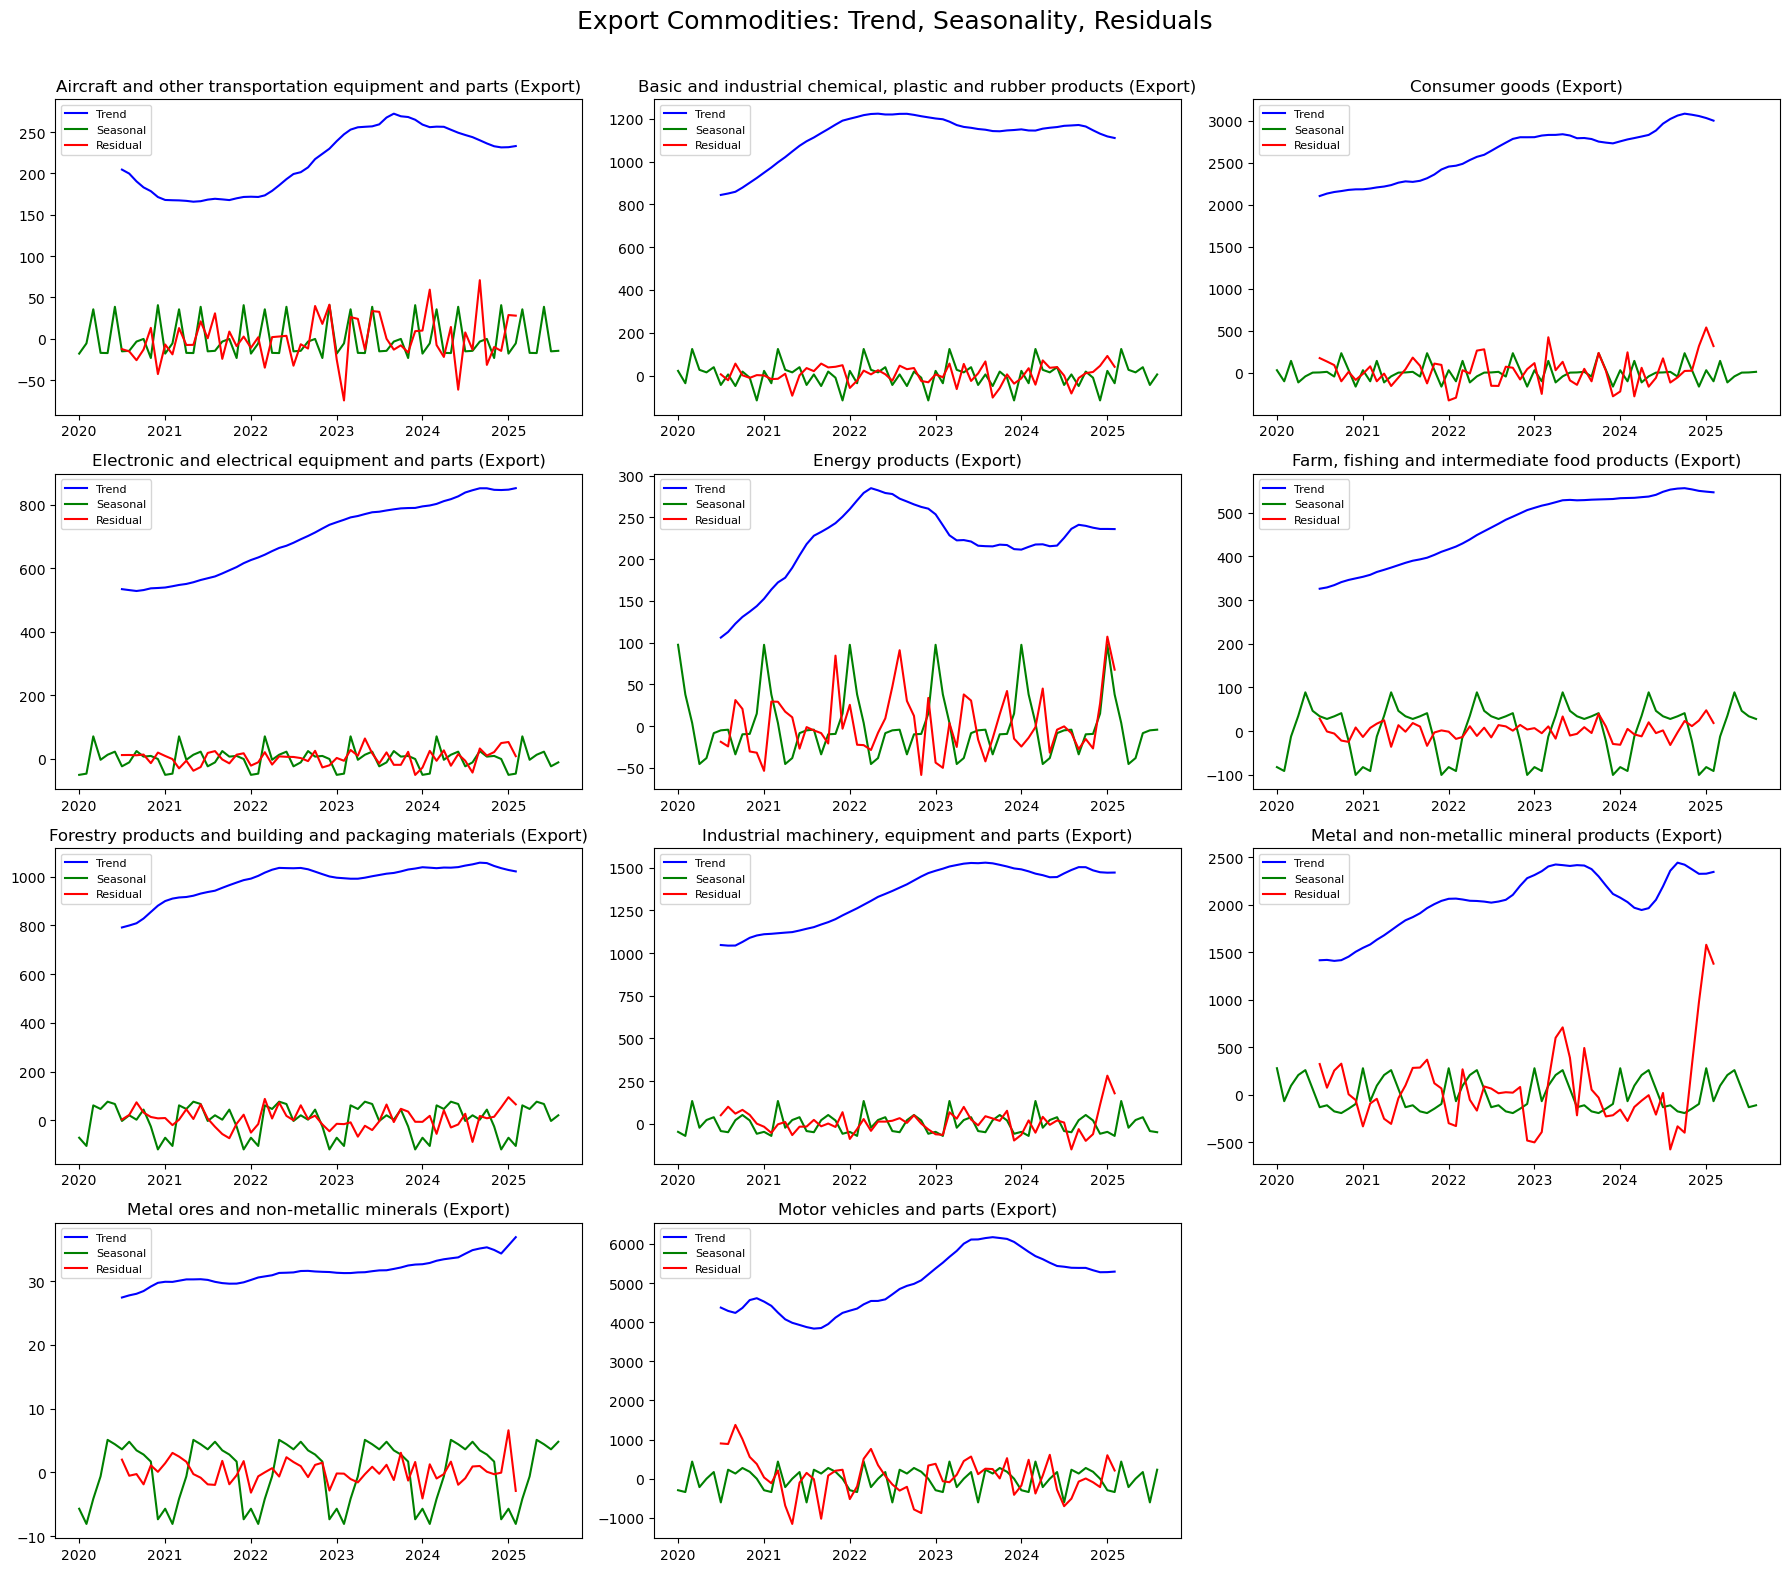

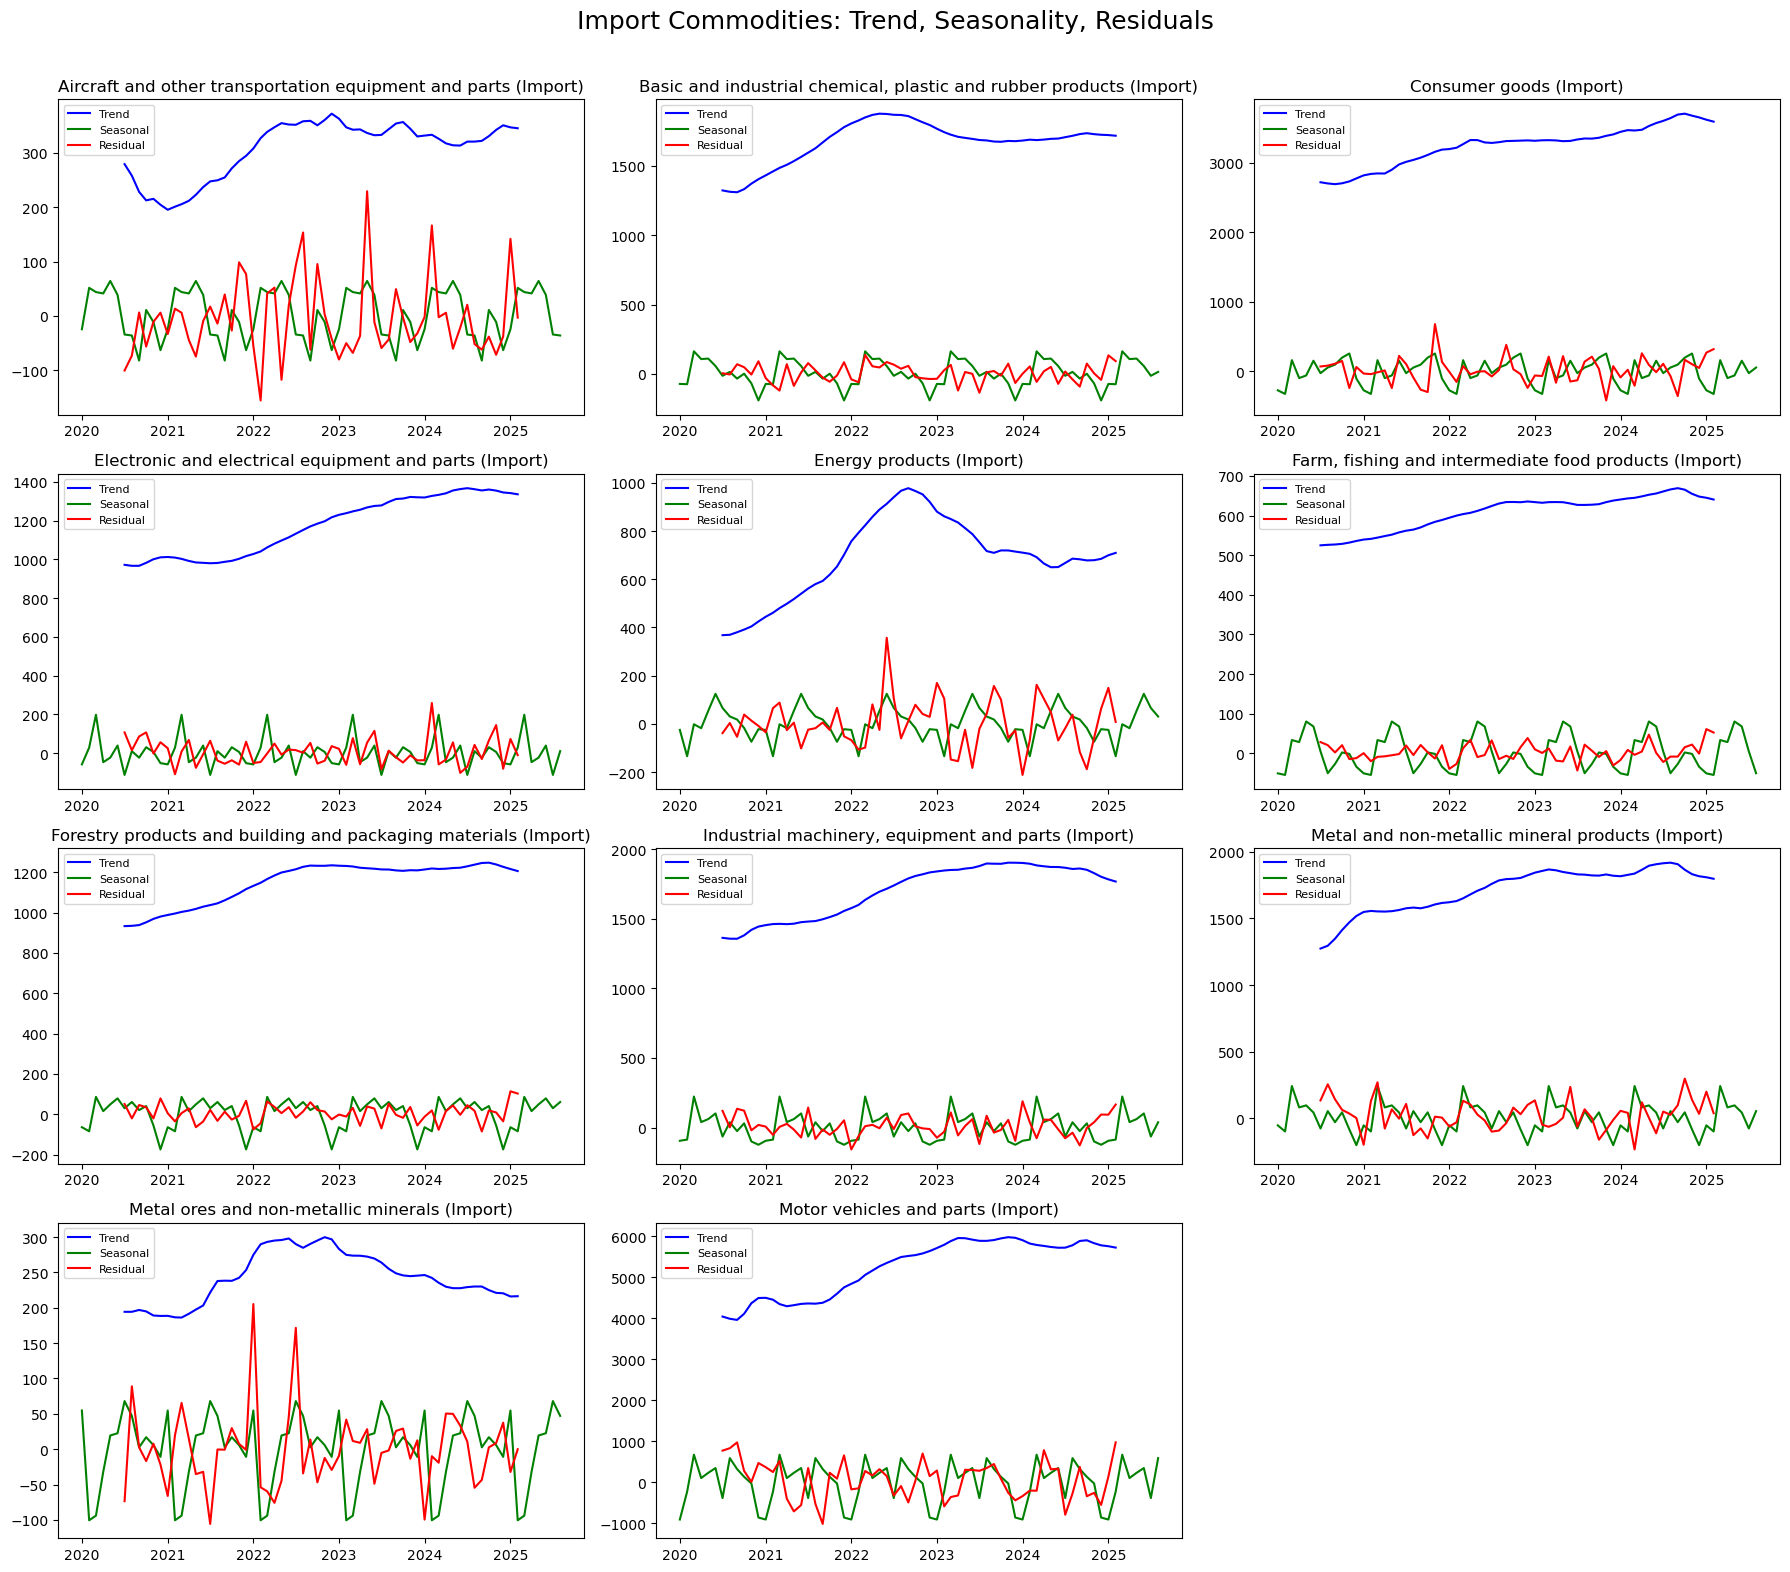

In [2]:
# ----------------------------
# Step 0: Imports
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum as spark_sum,when

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests

from prophet import Prophet

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# ============================================================
# Load & Filter Delta Table
# ============================================================
df = spark.read.format("delta").load("Tables/silver_napcs_ontario_us_trade_by_province_data")

# Add standardized trade type column
df = df.withColumn(
    "Trade_Type_Standardized",
    when(col("Trade_Type") == "Import", "Import")
    .when(col("Trade_Type").isin("Domestic export", "Re-export"), "Export")
    .otherwise(None)
)

# Filter out unwanted data
filtered_df = df.filter(
    (col("Region") == "Ontario") &
    (~col("NAPCS_Commodity_Description").isin(["Special transactions trade", "Total of all merchandise"])) &
    (col("Trade_Type_Standardized").isNotNull())
)

# Use Trade_Type_Standardized for filtering
export_df = filtered_df.filter(col("Trade_Type_Standardized") == "Export")
import_df = filtered_df.filter(col("Trade_Type_Standardized") == "Import")

# ============================================================
# Aggregation
# ============================================================
def aggregate_trade(trade_df):
    return (
        trade_df.groupBy("Year", "Month_Name", "NAPCS_Commodity_Description")
        .agg(spark_sum("Value_Millions").alias("Total_Value_Millions"))
        .toPandas()
    )

export_pd = aggregate_trade(export_df)
import_pd = aggregate_trade(import_df)

if export_pd.empty and import_pd.empty:
    raise ValueError("No data available after filtering/aggregation.")


# ----------------------------
# Step 2: Preprocessing
# ----------------------------
# Convert Year + Month_Name to datetime
month_map = {
    'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,
    'July':7,'August':8,'September':9,'October':10,'November':11,'December':12
}

def preprocess(df):
    df['Month'] = df['Month_Name'].map(month_map)
    df['period'] = pd.to_datetime(df[['Year','Month']].assign(DAY=1))
    df = df.sort_values('period')
    return df

export_pd = preprocess(export_pd)
import_pd = preprocess(import_pd)

# Pivot data for time series analysis (commodities as columns)
export_ts = export_pd.pivot(index='period', columns='NAPCS_Commodity_Description', values='Total_Value_Millions')
import_ts = import_pd.pivot(index='period', columns='NAPCS_Commodity_Description', values='Total_Value_Millions')


###############Final part###################################

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
from pyspark.sql import SparkSession

# Assuming SparkSession already exists
spark = SparkSession.builder.getOrCreate()

def analyze_and_save_to_tables(export_ts, import_ts, table_name="gold_trend_seasonality_data",
                               min_points=24, n_cols=3):
    """
    Analyze trend/seasonality/residuals for both Export and Import
    and write as a single Delta table under Tables/ in Fabric.
    """

    combined_detail = []

    # Helper function for each trade type
    def process_trade(ts_df, trade_type):
        detail_data = []

        n_commodities = len(ts_df.columns)
        n_rows = (n_commodities // n_cols) + (n_commodities % n_cols > 0)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*4))
        axes = axes.flatten()

        for i, commodity in enumerate(ts_df.columns):
            ts_series = ts_df[commodity].dropna()
            if len(ts_series) < min_points:
                axes[i].set_visible(False)
                continue

            decomposition = seasonal_decompose(ts_series, model='additive', period=12)

            # Plot decomposition (optional visualization)
            axes[i].plot(ts_series.index, decomposition.trend, label='Trend', color='blue')
            axes[i].plot(ts_series.index, decomposition.seasonal, label='Seasonal', color='green')
            axes[i].plot(ts_series.index, decomposition.resid, label='Residual', color='red')
            axes[i].set_title(f"{commodity} ({trade_type})")
            axes[i].legend(loc='upper left', fontsize=8)

            # --- Summary metrics ---
            trend_clean = decomposition.trend.dropna()
            trend_slope = (trend_clean.iloc[-1] - trend_clean.iloc[0]) / len(trend_clean)
            trend_direction = "Increasing" if trend_slope > 0 else "Decreasing"

            seasonal = decomposition.seasonal
            peak_month = seasonal.idxmax().strftime('%B')
            trough_month = seasonal.idxmin().strftime('%B')
            residual_vol = decomposition.resid.std()

            # Add detail row for each period with summary metrics
            for date, t, s, r in zip(ts_series.index, decomposition.trend, decomposition.seasonal, decomposition.resid):
                detail_data.append({
                    "Commodity": commodity,
                    "Trade_Type": trade_type,
                    "Period": date,
                    "Trend_Value": t,
                    "Seasonal_Value": s,
                    "Residual_Value": r,
                    "Trend_Direction": trend_direction,
                    "Peak_Season": peak_month,
                    "Trough_Season": trough_month,
                    "Residual_Volatility": residual_vol
                })

        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle(f"{trade_type} Commodities: Trend, Seasonality, Residuals", fontsize=18)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()

        return detail_data

    # Process both Export and Import
    export_detail = process_trade(export_ts, "Export")
    import_detail = process_trade(import_ts, "Import")

    combined_detail = export_detail + import_detail

    # Convert to Spark DataFrame
    combined_spark = spark.createDataFrame(pd.DataFrame(combined_detail))

    # ✅ Parameterized write to Gold Lakehouse table
    gold_base_path = "abfss://1dcd65a7-d5a3-4e2b-a110-db438703b7b5@onelake.dfs.fabric.microsoft.com/e14547c6-561b-467b-bef2-943e66043393/Tables"
    combined_spark.write \
        .format("delta") \
        .mode("overwrite") \
        .option("overwriteSchema", "true") \
        .save(f"{gold_base_path}/{table_name}")


    

    return pd.DataFrame(combined_detail)

# ----------------------------
# Run analysis and save
# ----------------------------
combined_full_df = analyze_and_save_to_tables(
    export_ts, import_ts, table_name="gold_trend_seasonality_data")


StatementMeta(, b700f20a-7c0f-4d83-9cc9-473aa3b882d2, 5, Finished, Available, Finished)

19:46:04 - cmdstanpy - INFO - Chain [1] start processing
19:46:04 - cmdstanpy - INFO - Chain [1] done processing


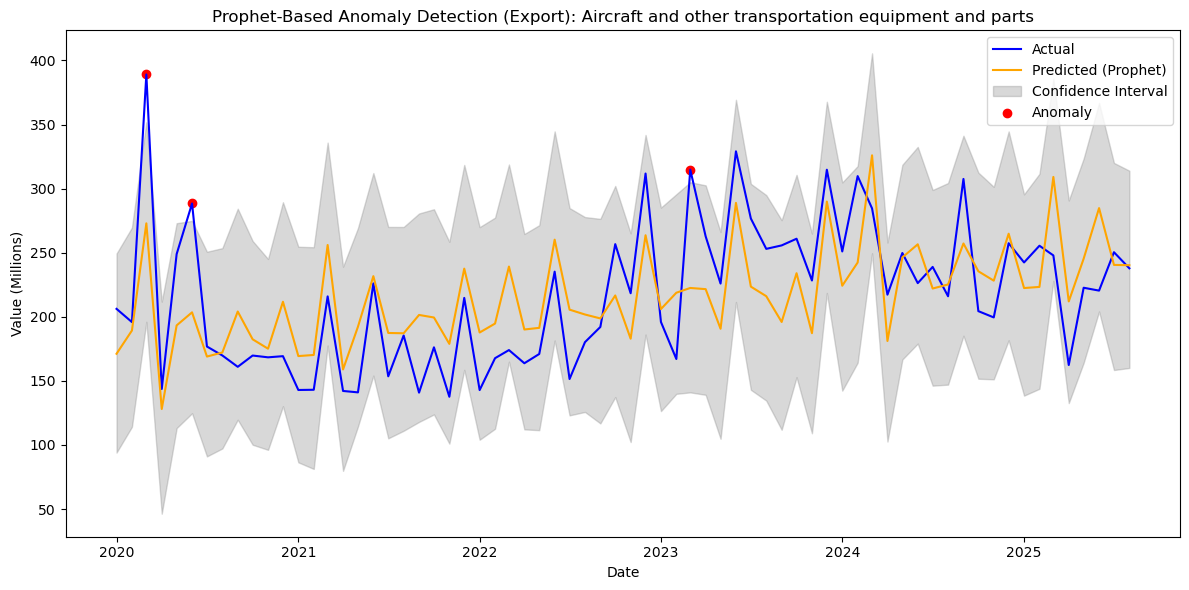

19:46:05 - cmdstanpy - INFO - Chain [1] start processing
19:46:05 - cmdstanpy - INFO - Chain [1] done processing


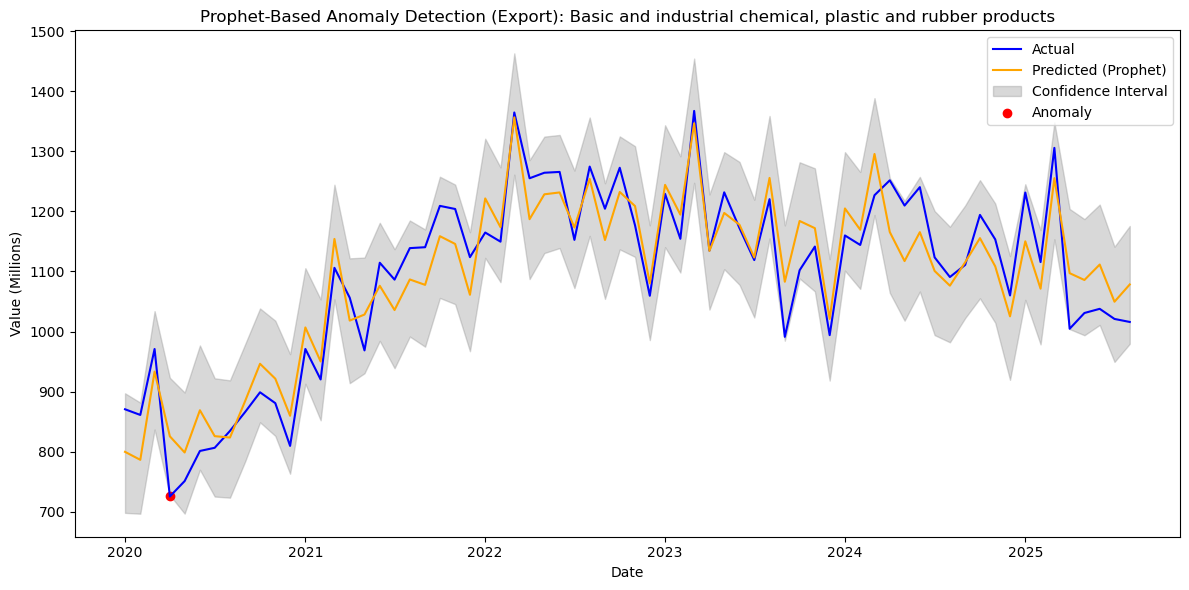

19:46:05 - cmdstanpy - INFO - Chain [1] start processing
19:46:06 - cmdstanpy - INFO - Chain [1] done processing


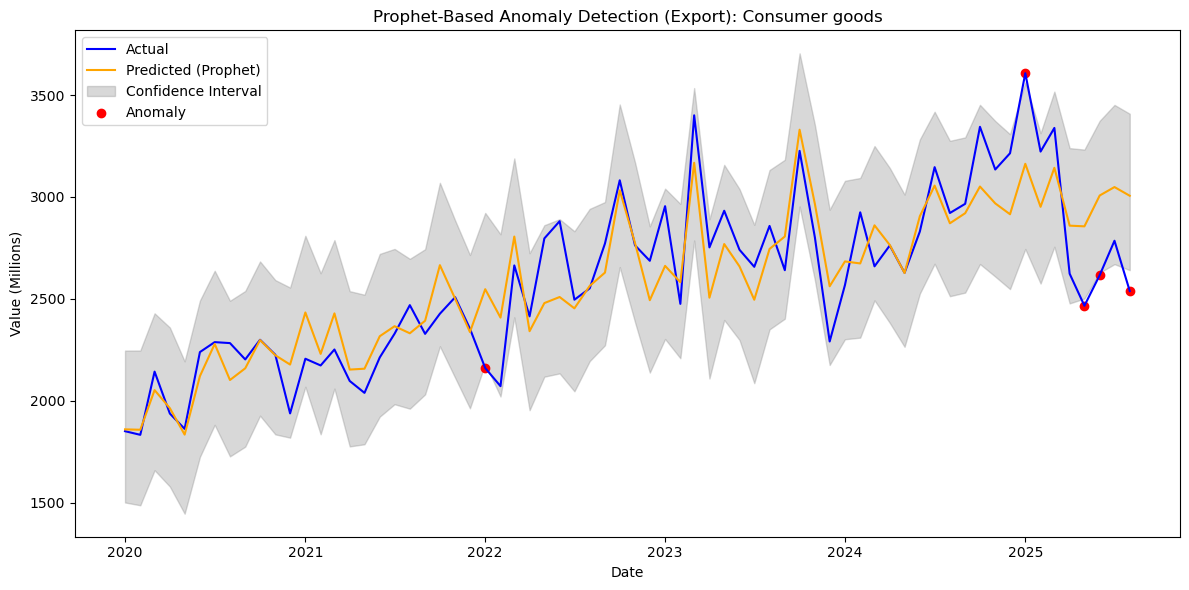

19:46:06 - cmdstanpy - INFO - Chain [1] start processing
19:46:06 - cmdstanpy - INFO - Chain [1] done processing


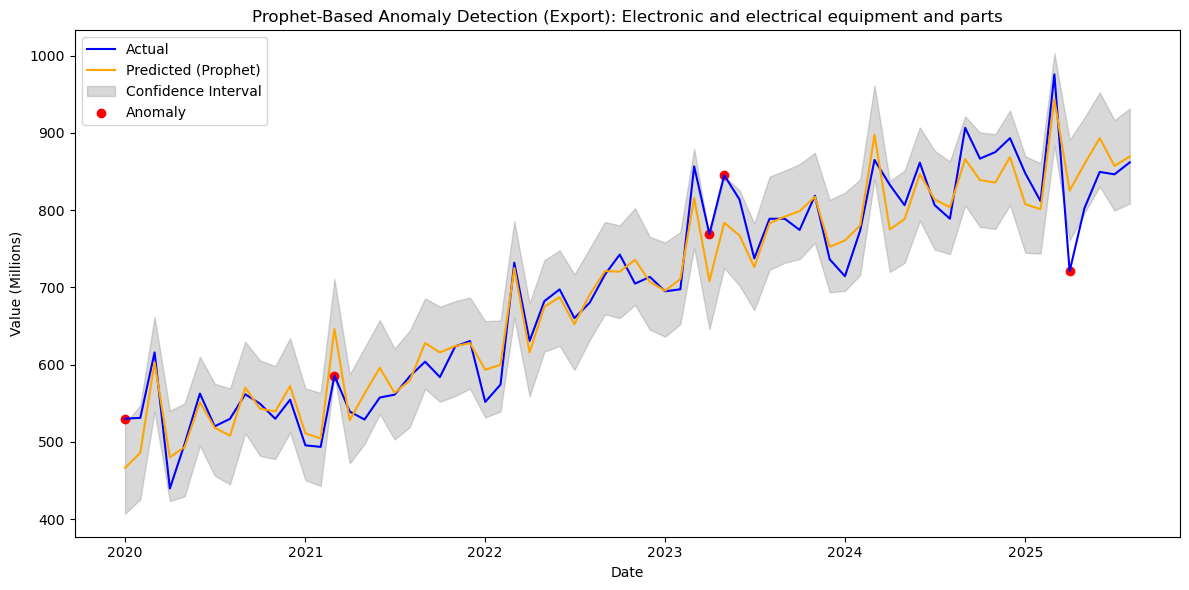

19:46:07 - cmdstanpy - INFO - Chain [1] start processing
19:46:07 - cmdstanpy - INFO - Chain [1] done processing


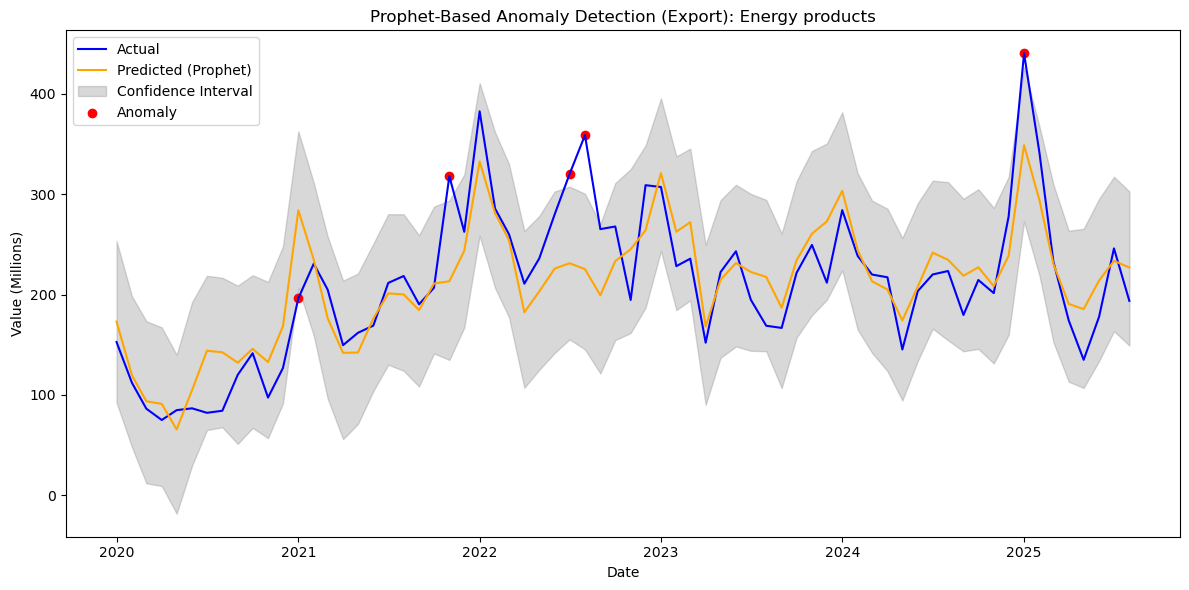

19:46:07 - cmdstanpy - INFO - Chain [1] start processing
19:46:07 - cmdstanpy - INFO - Chain [1] done processing


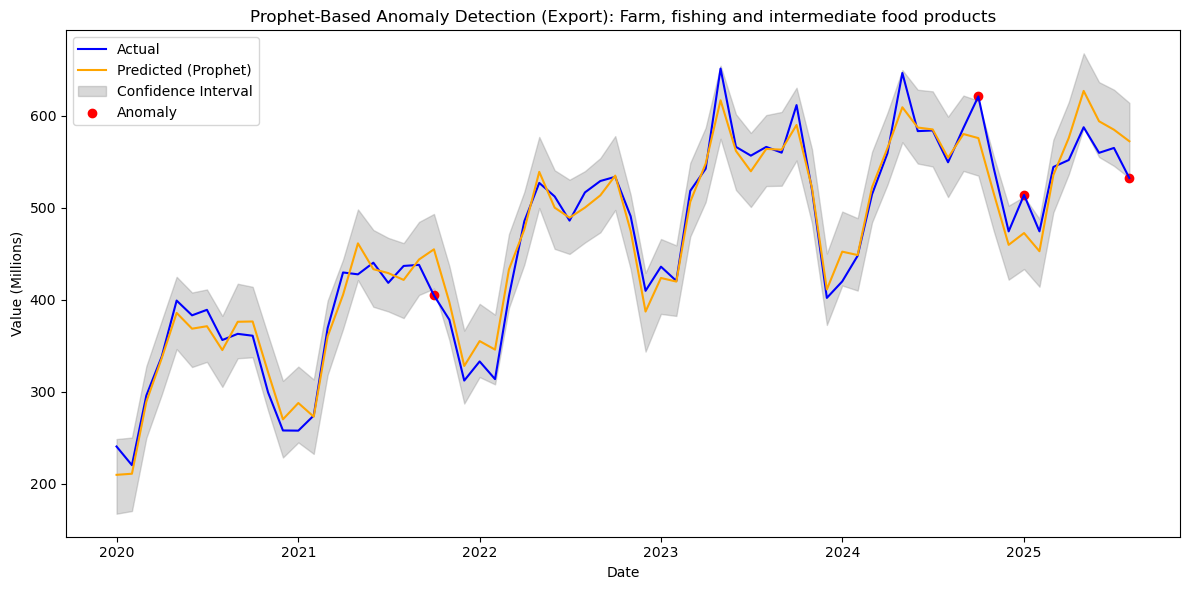

19:46:08 - cmdstanpy - INFO - Chain [1] start processing
19:46:08 - cmdstanpy - INFO - Chain [1] done processing


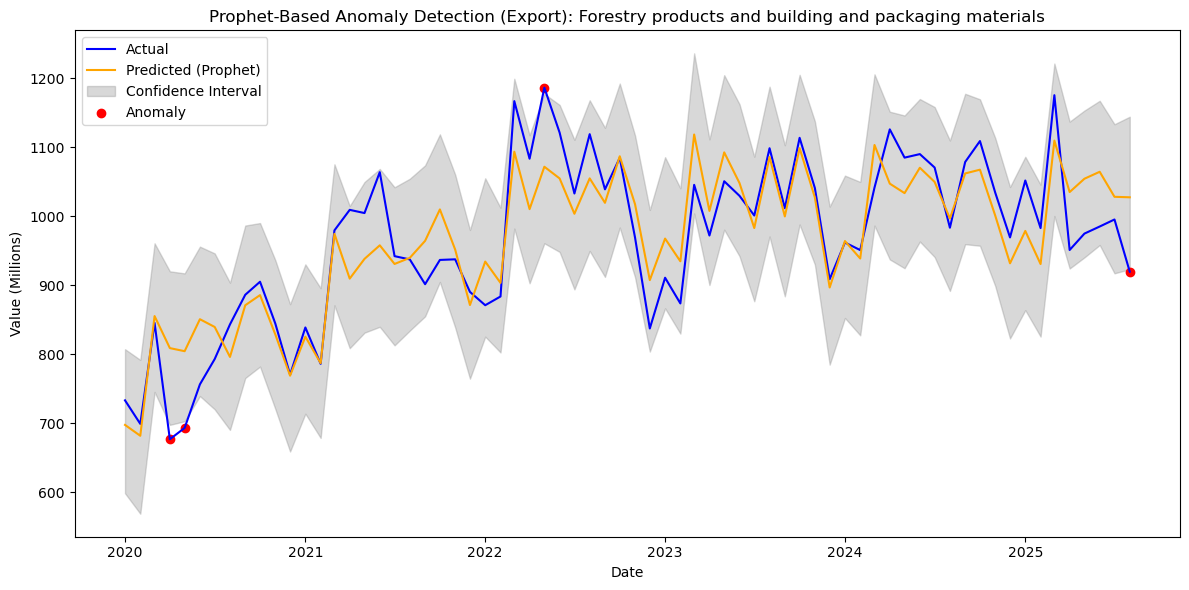

19:46:08 - cmdstanpy - INFO - Chain [1] start processing
19:46:09 - cmdstanpy - INFO - Chain [1] done processing


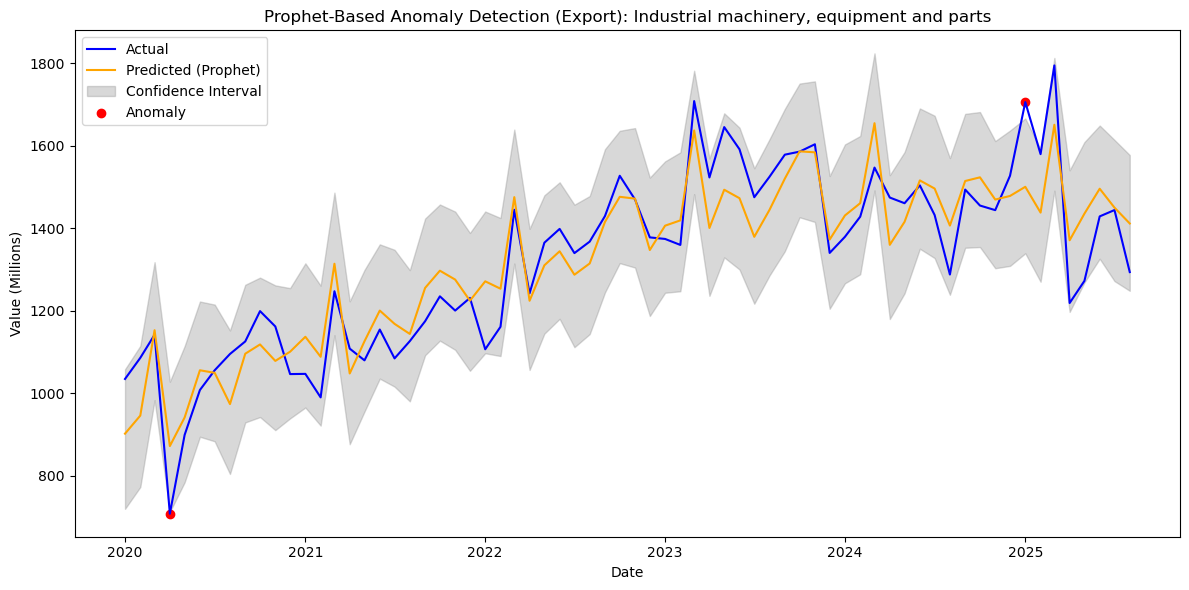

19:46:09 - cmdstanpy - INFO - Chain [1] start processing
19:46:09 - cmdstanpy - INFO - Chain [1] done processing


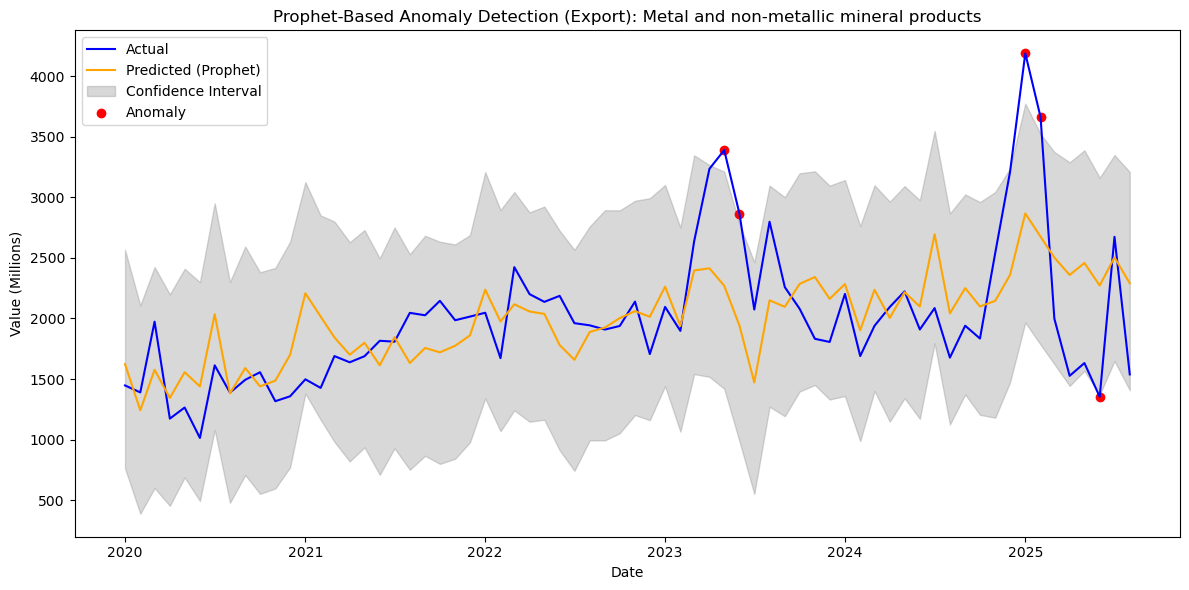

19:46:10 - cmdstanpy - INFO - Chain [1] start processing
19:46:10 - cmdstanpy - INFO - Chain [1] done processing


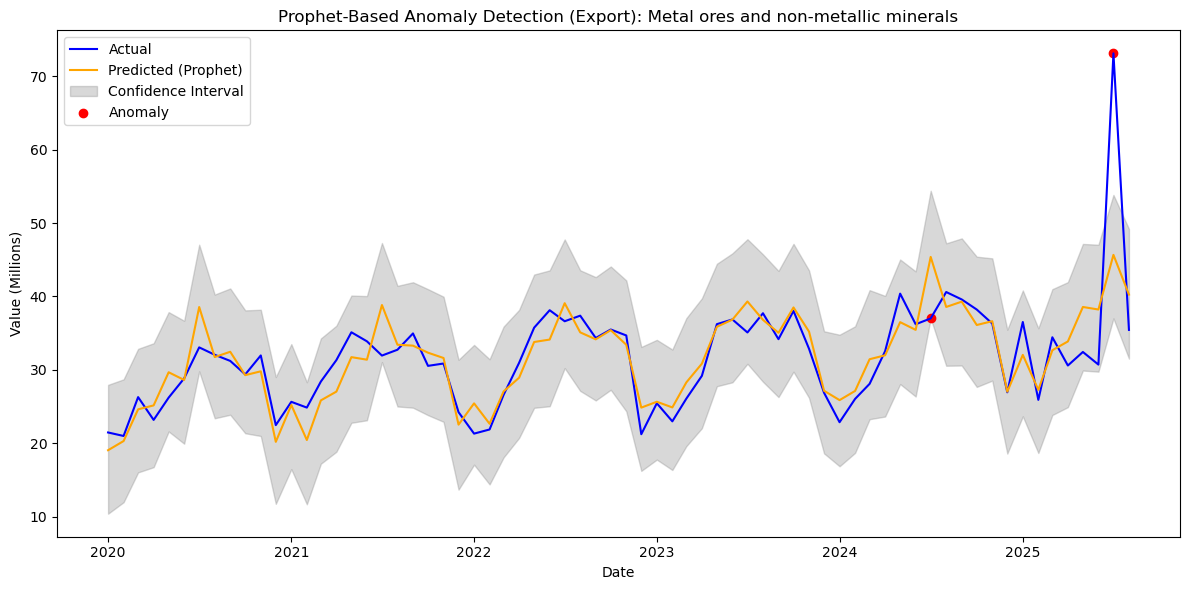

19:46:10 - cmdstanpy - INFO - Chain [1] start processing
19:46:10 - cmdstanpy - INFO - Chain [1] done processing


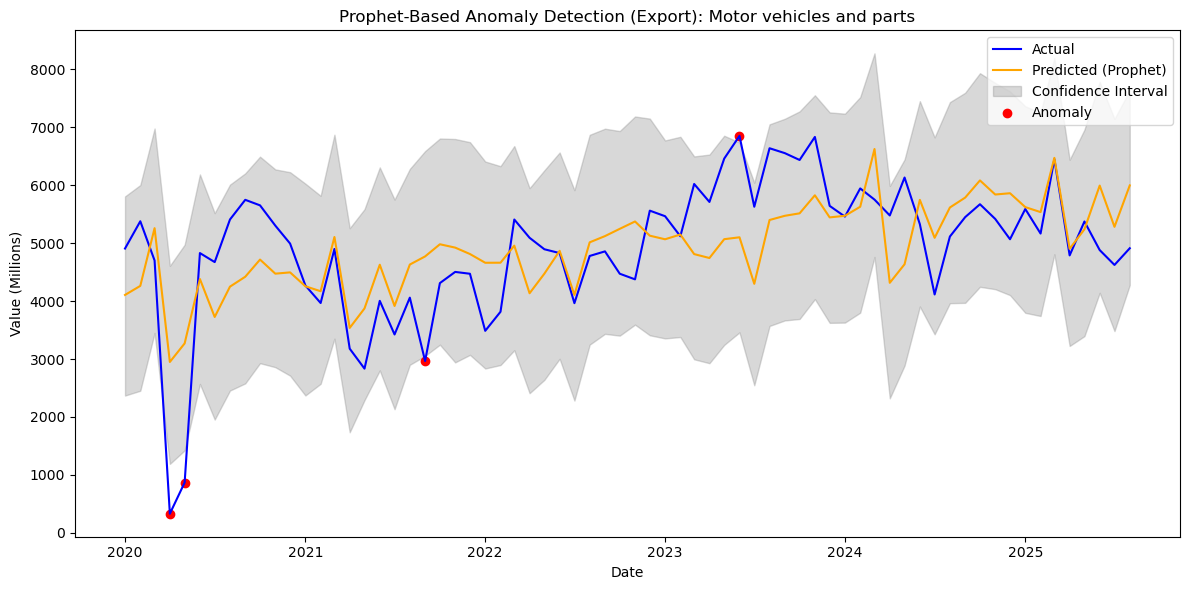

19:46:11 - cmdstanpy - INFO - Chain [1] start processing
19:46:11 - cmdstanpy - INFO - Chain [1] done processing


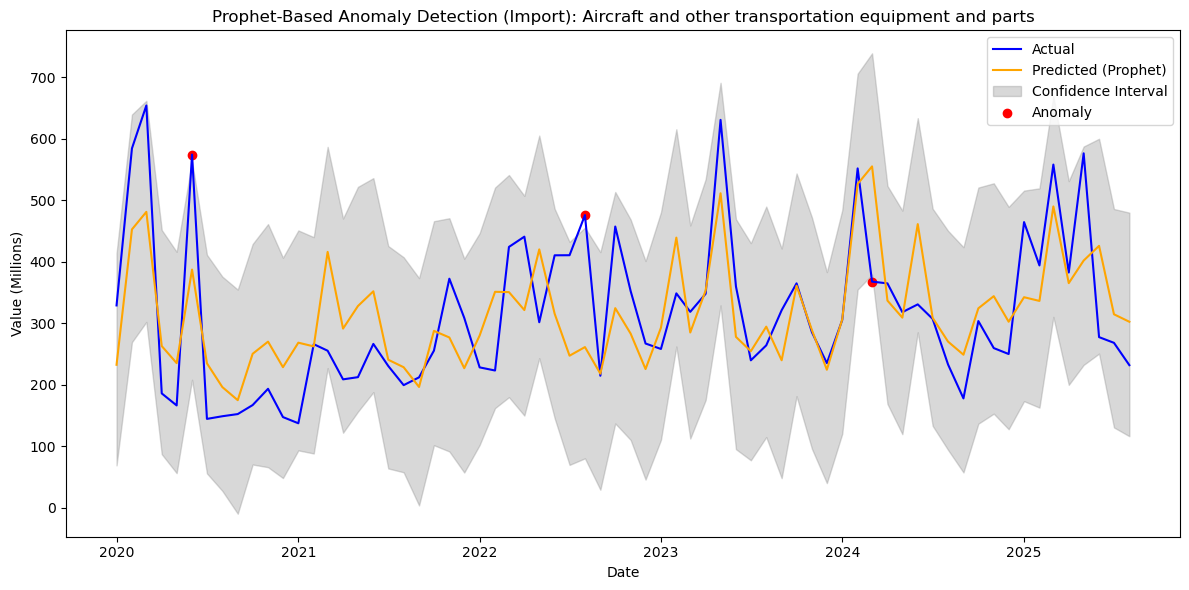

19:46:11 - cmdstanpy - INFO - Chain [1] start processing
19:46:12 - cmdstanpy - INFO - Chain [1] done processing


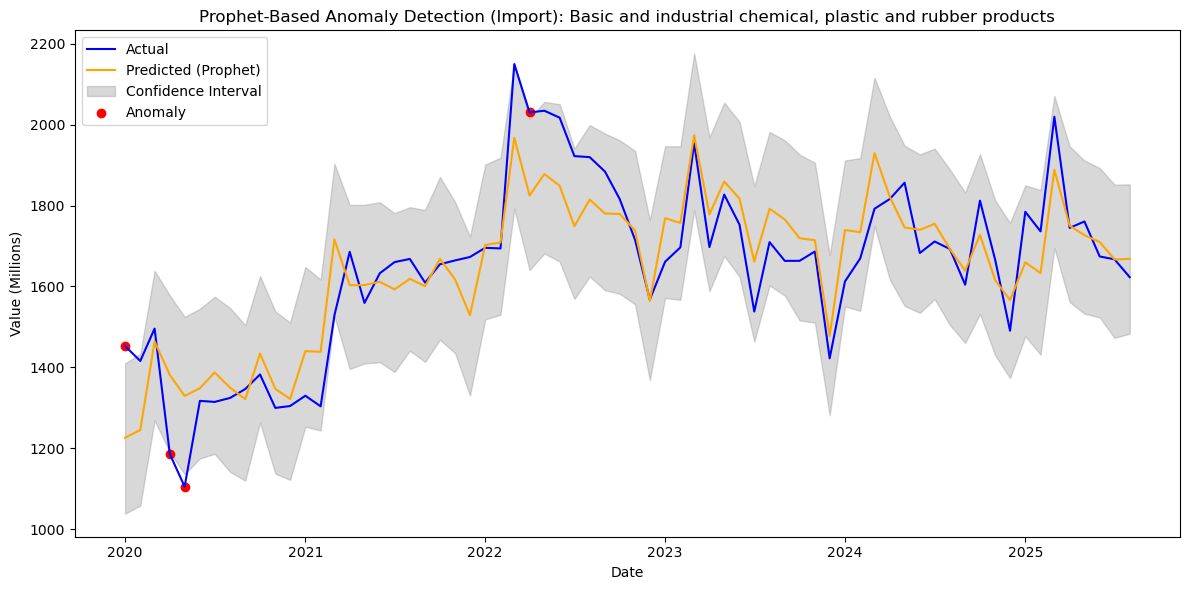

19:46:12 - cmdstanpy - INFO - Chain [1] start processing
19:46:12 - cmdstanpy - INFO - Chain [1] done processing


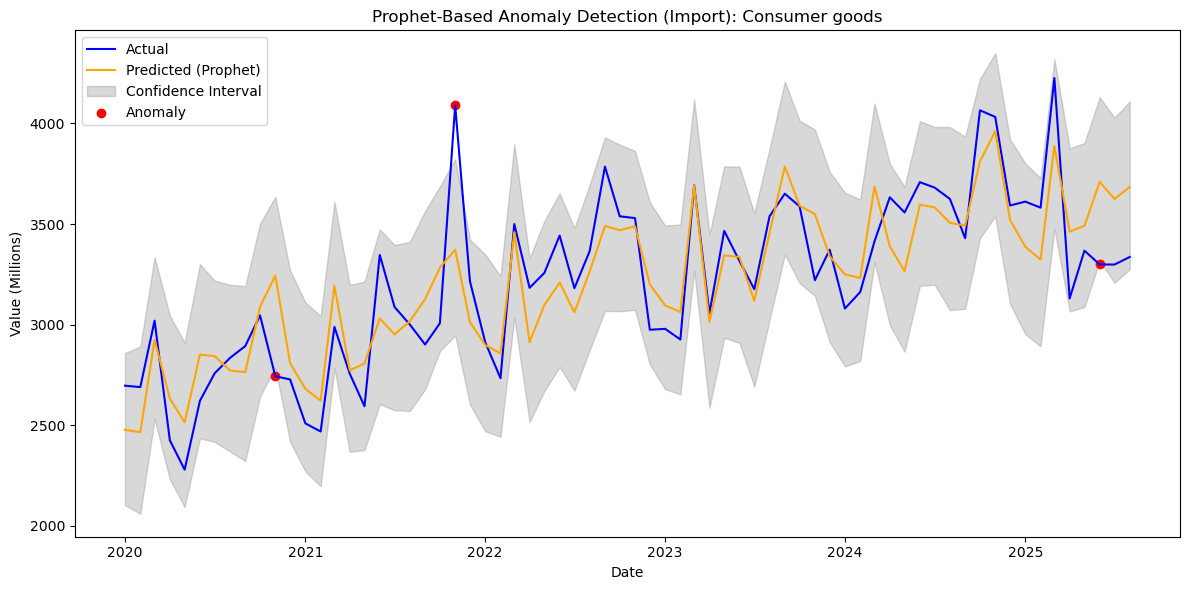

19:46:12 - cmdstanpy - INFO - Chain [1] start processing
19:46:13 - cmdstanpy - INFO - Chain [1] done processing


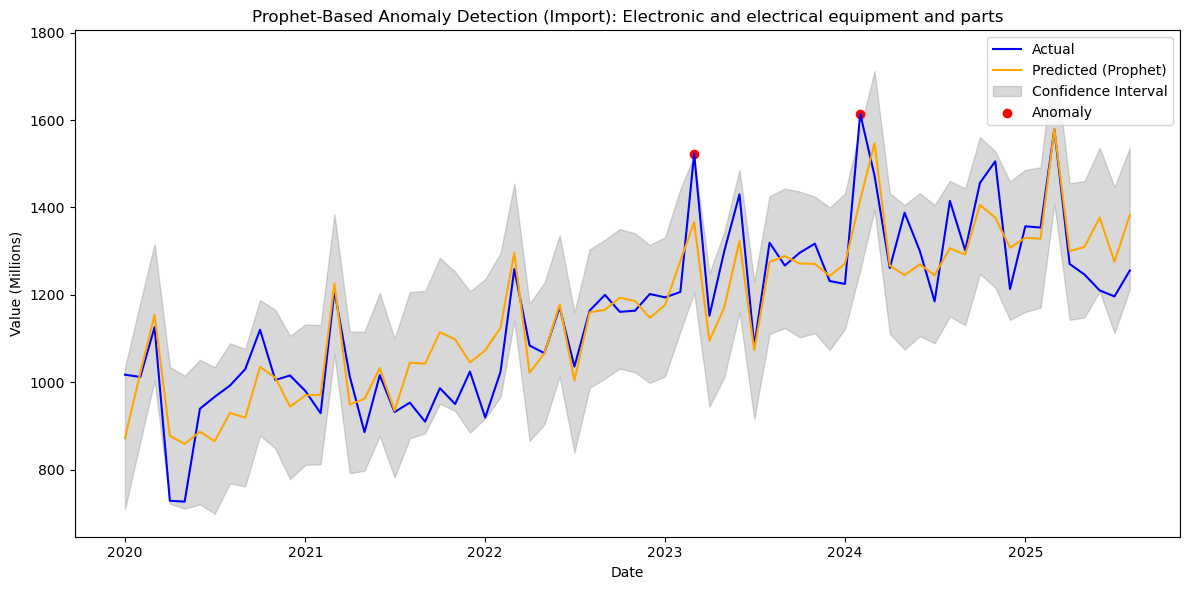

19:46:13 - cmdstanpy - INFO - Chain [1] start processing
19:46:13 - cmdstanpy - INFO - Chain [1] done processing


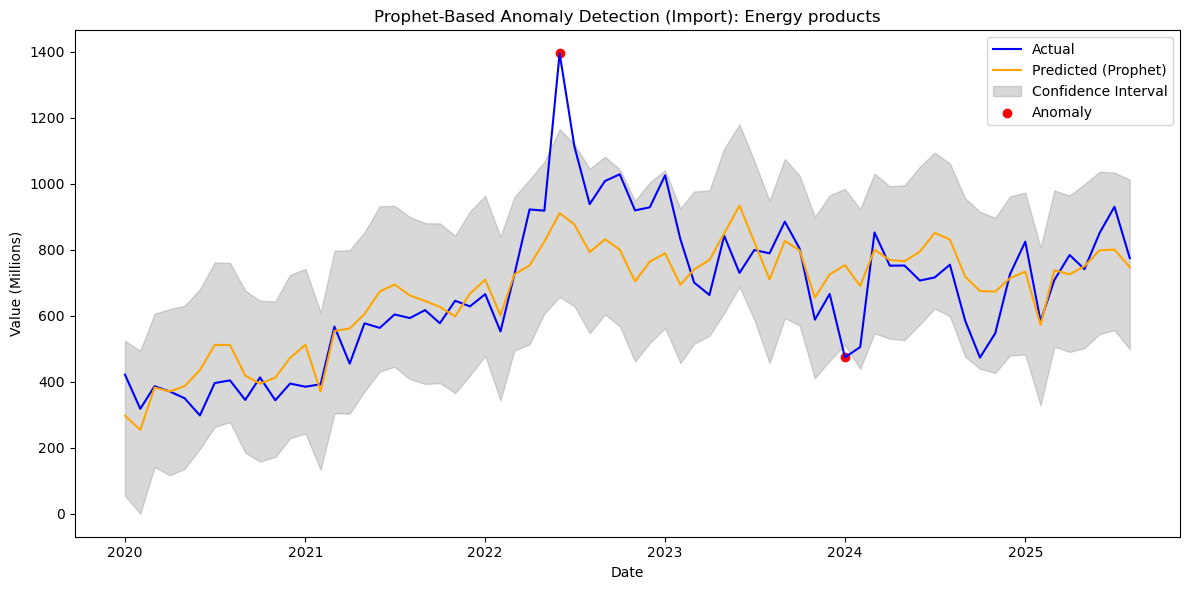

19:46:13 - cmdstanpy - INFO - Chain [1] start processing
19:46:14 - cmdstanpy - INFO - Chain [1] done processing


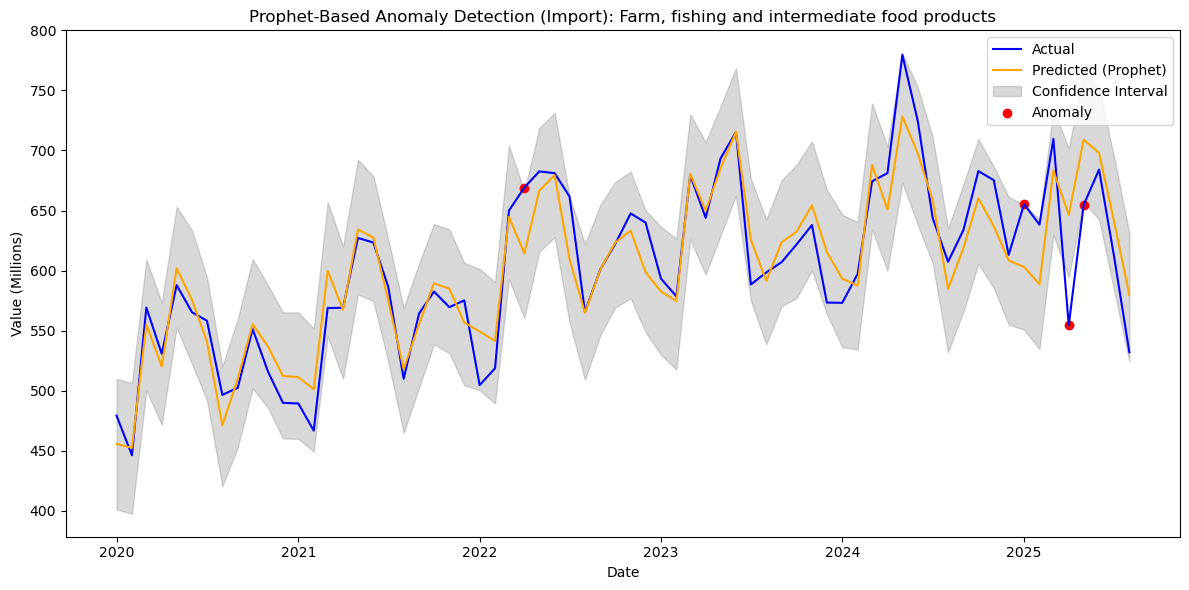

19:46:14 - cmdstanpy - INFO - Chain [1] start processing
19:46:14 - cmdstanpy - INFO - Chain [1] done processing


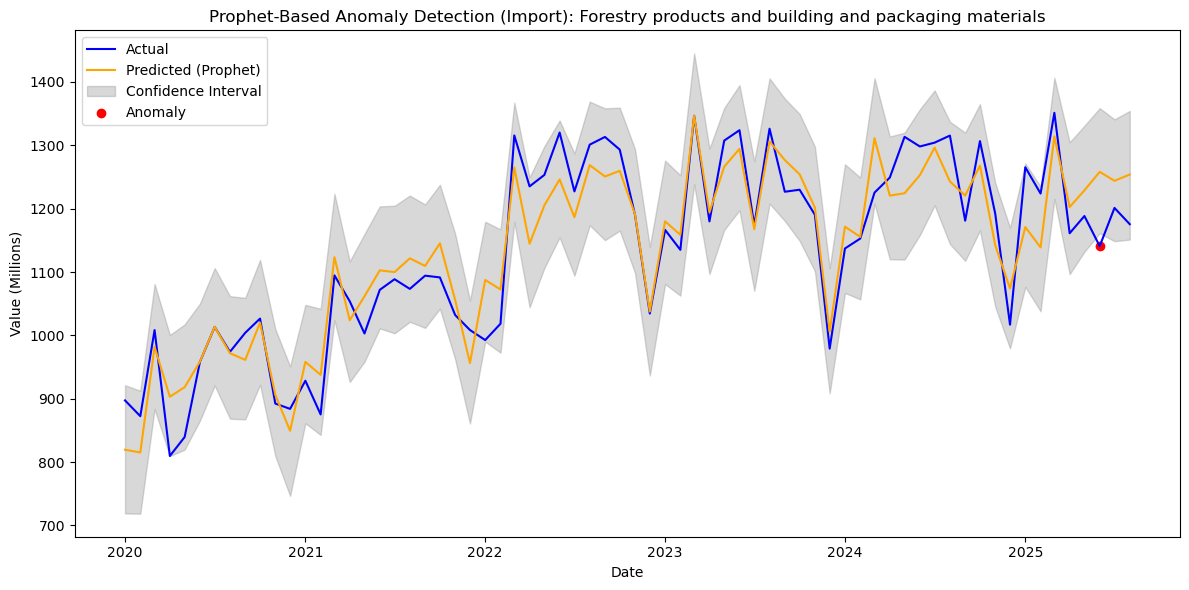

19:46:15 - cmdstanpy - INFO - Chain [1] start processing
19:46:15 - cmdstanpy - INFO - Chain [1] done processing


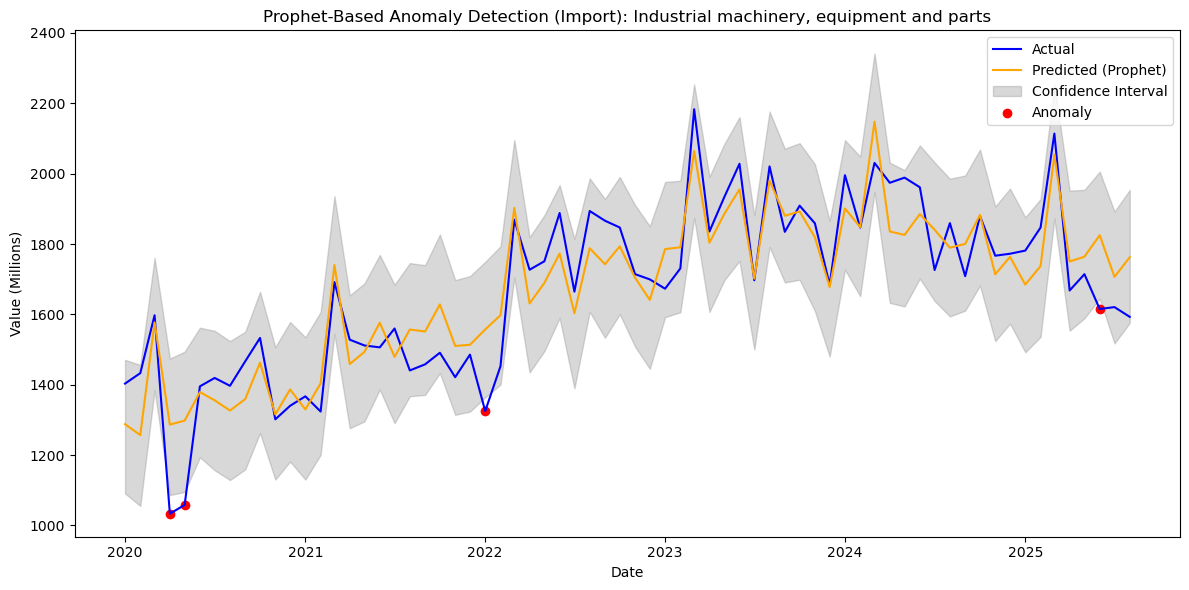

19:46:15 - cmdstanpy - INFO - Chain [1] start processing
19:46:15 - cmdstanpy - INFO - Chain [1] done processing


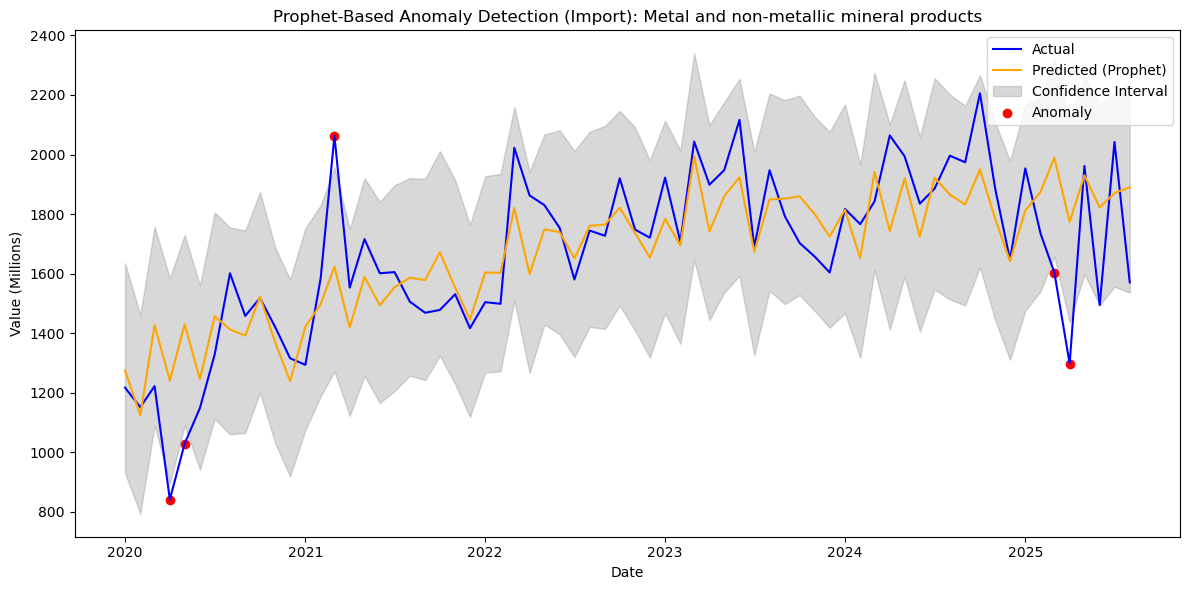

19:46:16 - cmdstanpy - INFO - Chain [1] start processing
19:46:16 - cmdstanpy - INFO - Chain [1] done processing


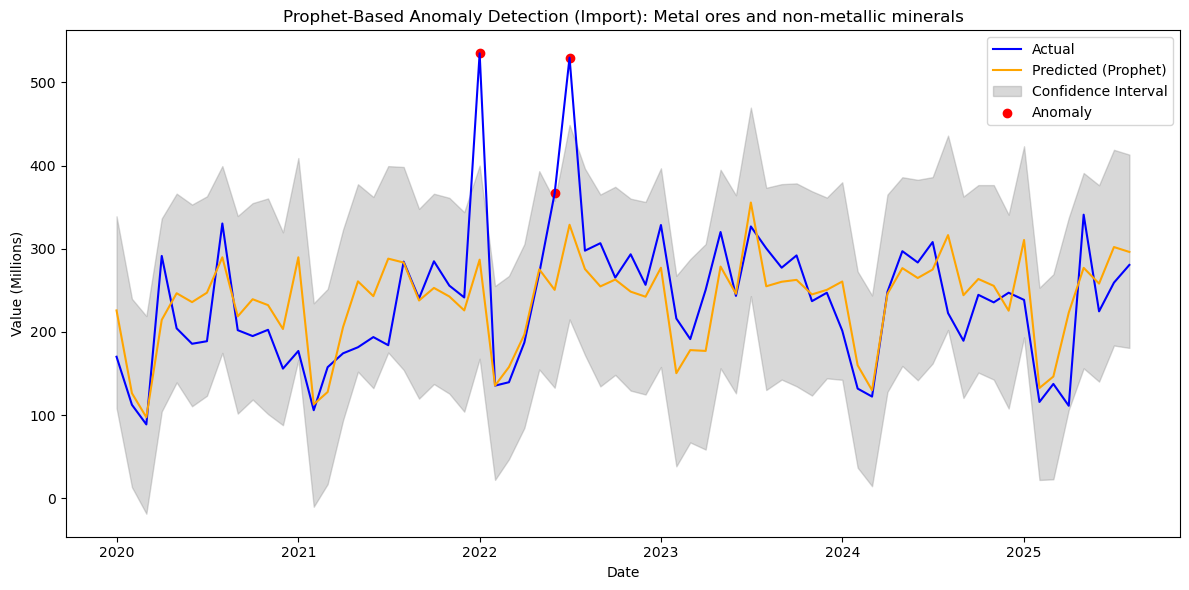

19:46:16 - cmdstanpy - INFO - Chain [1] start processing
19:46:16 - cmdstanpy - INFO - Chain [1] done processing


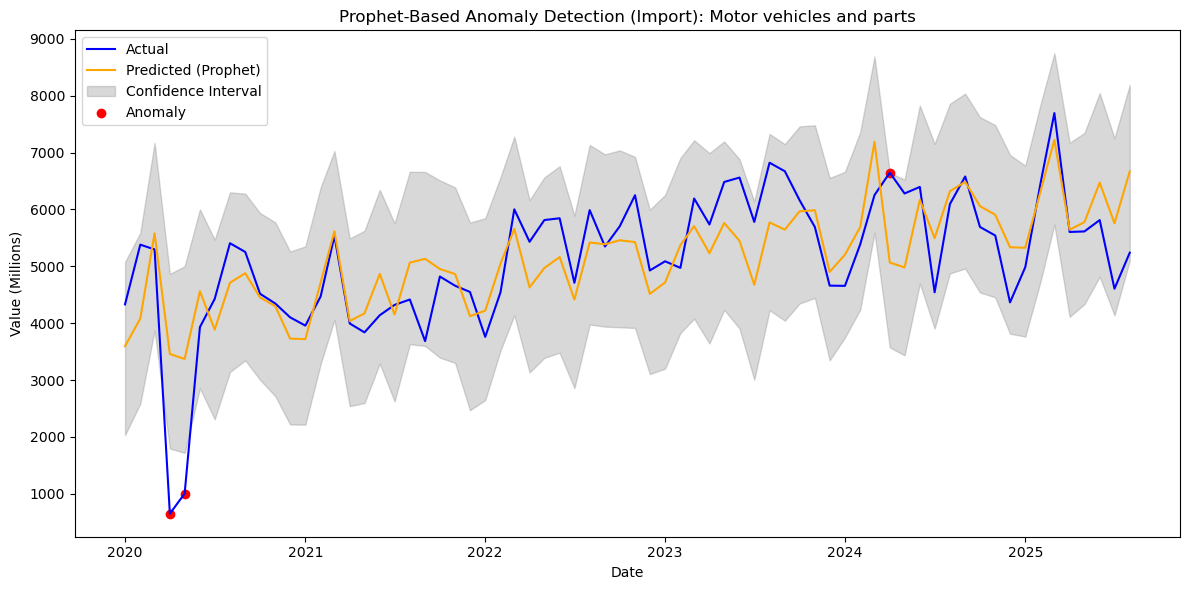

✅ Prophet-based anomaly detection results (with visualization) saved to Tables/gold_anomaly_detection_data


In [3]:
# ----------------------------
# Step 4: Prophet-based Anomaly Detection (with visualization + Delta output)
# ----------------------------
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

def detect_anomalies_prophet(ts_df, commodity, trade_type, interval_width=0.95, plot=True):
    """
    Detect anomalies using Prophet forecast intervals.
    Points outside Prophet's prediction bounds are flagged as anomalies.
    """

    # Prepare data for Prophet
    series = ts_df[commodity].dropna().reset_index()
    series.columns = ['ds', 'y']  # Prophet expects these names

    # Fit Prophet model
    model = Prophet(
        interval_width=interval_width,
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    model.fit(series)

    # Forecast (same historical range)
    future = model.make_future_dataframe(periods=0, freq='MS')
    forecast = model.predict(future)

    # Merge forecast with original data
    merged = pd.merge(series, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

    # Identify anomalies
    merged['Anomaly_Flag'] = 0
    merged.loc[merged['y'] > merged['yhat_upper'], 'Anomaly_Flag'] = 1   # Higher than expected
    merged.loc[merged['y'] < merged['yhat_lower'], 'Anomaly_Flag'] = -1  # Lower than expected
    merged['Trade_Type'] = trade_type
    merged['Commodity'] = commodity

    anomalies = merged[merged['Anomaly_Flag'] != 0]

    # Visualization (with confidence intervals)
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(merged['ds'], merged['y'], color='blue', label='Actual')
        plt.plot(merged['ds'], merged['yhat'], color='orange', label='Predicted (Prophet)')
        plt.fill_between(
            merged['ds'],
            merged['yhat_lower'],
            merged['yhat_upper'],
            color='gray',
            alpha=0.3,
            label='Confidence Interval'
        )
        plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomaly')
        plt.title(f"Prophet-Based Anomaly Detection ({trade_type}): {commodity}")
        plt.xlabel("Date")
        plt.ylabel("Value (Millions)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return merged


# ----------------------------
# Run for all commodities (Export & Import)
# ----------------------------
all_results = []

# Exports
for c in export_ts.columns:
    try:
        result = detect_anomalies_prophet(export_ts, c, trade_type="Export", plot=True)
        all_results.append(result)
    except Exception as e:
        print(f"Skipped {c} (Export) due to error: {e}")

# Imports
for c in import_ts.columns:
    try:
        result = detect_anomalies_prophet(import_ts, c, trade_type="Import", plot=True)
        all_results.append(result)
    except Exception as e:
        print(f"Skipped {c} (Import) due to error: {e}")

# ----------------------------
# Combine and write to Delta Table
# ----------------------------
combined_results = pd.concat(all_results, ignore_index=True)

# Convert to Spark DataFrame
combined_spark = spark.createDataFrame(combined_results)

# Save to Delta Table (Power BI can connect directly)
combined_spark.write.format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .save("abfss://1dcd65a7-d5a3-4e2b-a110-db438703b7b5@onelake.dfs.fabric.microsoft.com/e14547c6-561b-467b-bef2-943e66043393/Tables/gold_anomaly_detection_data")

print("✅ Prophet-based anomaly detection results (with visualization) saved to Tables/gold_anomaly_detection_data")


StatementMeta(, b700f20a-7c0f-4d83-9cc9-473aa3b882d2, 6, Finished, Available, Finished)

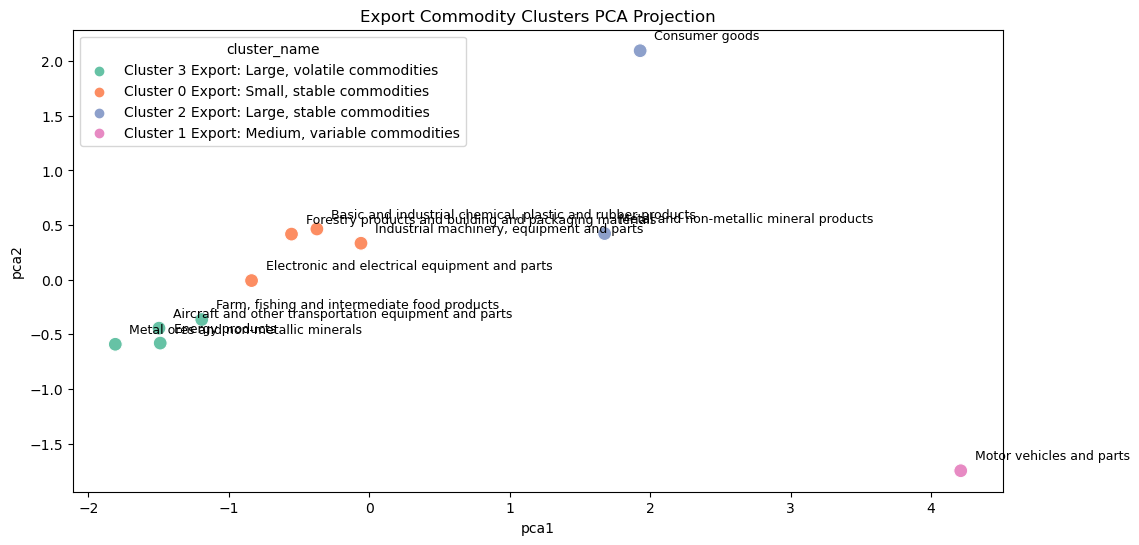

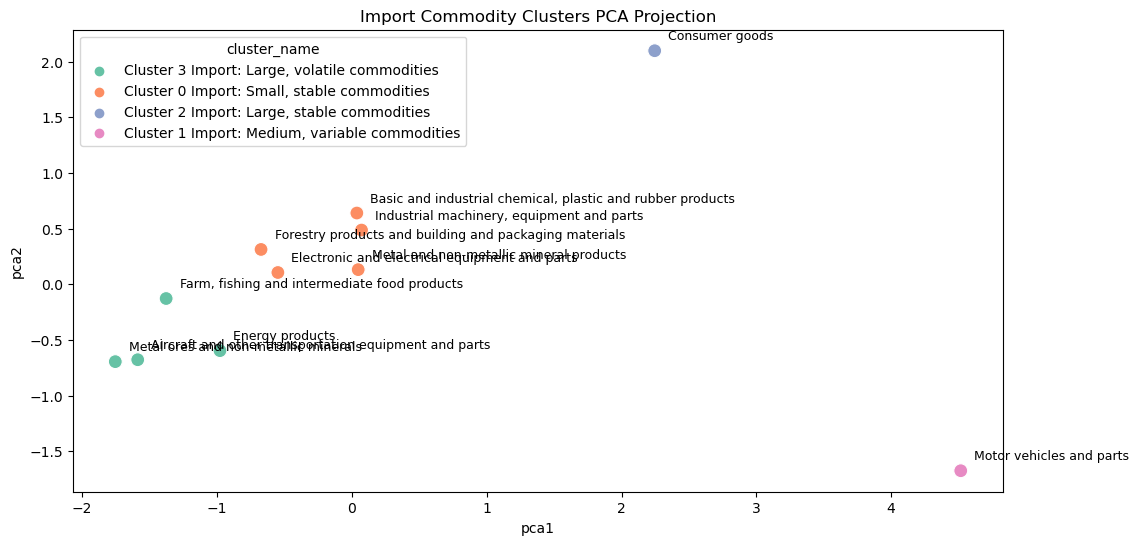

In [4]:
# ----------------------------
# Dynamic Export/Import Clustering with Descriptive Cluster Names (Separate Visualizations)
# ----------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# ----------------------------
# Function to perform clustering for a given trade type
# ----------------------------
def cluster_commodities(ts_df, trade_type, n_clusters=4):
    # Compute basic stats per commodity
    features = ts_df.agg(['mean','std','max','min']).T.fillna(0)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)
    
    # K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    features['cluster'] = kmeans.fit_predict(X_scaled)
    
    # PCA for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled)
    features['pca1'] = pca_result[:,0]
    features['pca2'] = pca_result[:,1]
    
    # Add trade type and commodity name
    features['Trade_Type_Standardized'] = trade_type
    features['Commodity'] = features.index
    
    return features.reset_index(drop=True)

# ----------------------------
# Apply clustering for Export and Import
# ----------------------------
export_clusters = cluster_commodities(export_ts, trade_type='Export', n_clusters=4)
import_clusters = cluster_commodities(import_ts, trade_type='Import', n_clusters=4)

# ----------------------------
# Assign dynamic descriptive names based on cluster numbers
# ----------------------------
cluster_labels = {
    'Export': {
        0: "Cluster 0 Export: Small, stable commodities",
        1: "Cluster 1 Export: Medium, variable commodities",
        2: "Cluster 2 Export: Large, stable commodities",
        3: "Cluster 3 Export: Large, volatile commodities"
    },
    'Import': {
        0: "Cluster 0 Import: Small, stable commodities",
        1: "Cluster 1 Import: Medium, variable commodities",
        2: "Cluster 2 Import: Large, stable commodities",
        3: "Cluster 3 Import: Large, volatile commodities"
    }
}

export_clusters['cluster_name'] = export_clusters.apply(
    lambda row: cluster_labels['Export'][row['cluster']], axis=1
)
import_clusters['cluster_name'] = import_clusters.apply(
    lambda row: cluster_labels['Import'][row['cluster']], axis=1
)

# ----------------------------
# Save combined clusters to Delta Table
# ----------------------------
combined_clusters = pd.concat([export_clusters, import_clusters], axis=0).reset_index(drop=True)
combined_spark = spark.createDataFrame(combined_clusters)

combined_spark.write.format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .save("abfss://1dcd65a7-d5a3-4e2b-a110-db438703b7b5@onelake.dfs.fabric.microsoft.com/e14547c6-561b-467b-bef2-943e66043393/Tables/gold_clustering_data")

# ----------------------------
# Visualize Export separately
# ----------------------------
plt.figure(figsize=(12,6))
sns.scatterplot(
    x='pca1', y='pca2', 
    hue='cluster_name',
    data=export_clusters, palette='Set2', s=100
)
for i, txt in enumerate(export_clusters['Commodity']):
    plt.text(export_clusters['pca1'][i]+0.1, export_clusters['pca2'][i]+0.1, txt, fontsize=9)
plt.title("Export Commodity Clusters PCA Projection")
plt.show()

# ----------------------------
# Visualize Import separately
# ----------------------------
plt.figure(figsize=(12,6))
sns.scatterplot(
    x='pca1', y='pca2', 
    hue='cluster_name',
    data=import_clusters, palette='Set2', s=100
)
for i, txt in enumerate(import_clusters['Commodity']):
    plt.text(import_clusters['pca1'][i]+0.1, import_clusters['pca2'][i]+0.1, txt, fontsize=9)
plt.title("Import Commodity Clusters PCA Projection")
plt.show()


In [5]:
# ----------------------------
# Step 0: Imports
# ----------------------------
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pyspark.sql import SparkSession

# Initialize Spark
spark = SparkSession.builder.getOrCreate()

# ============================================================
# Load & Filter Delta Table
# ============================================================
df = spark.read.format("delta").load("Tables/silver_napcs_ontario_us_trade_by_province_data")

# Add standardized trade type column
df = df.withColumn(
    "Trade_Type_Standardized",
    when(col("Trade_Type") == "Import", "Import")
    .when(col("Trade_Type").isin("Domestic export", "Re-export"), "Export")
    .otherwise(None)
)

# Filter out unwanted data
filtered_df = df.filter(
    (col("Region") == "Ontario") &
    (~col("NAPCS_Commodity_Description").isin(["Special transactions trade", "Total of all merchandise"])) &
    (col("Trade_Type_Standardized").isNotNull())
)

# Use Trade_Type_Standardized for filtering
export_df = filtered_df.filter(col("Trade_Type_Standardized") == "Export")
import_df = filtered_df.filter(col("Trade_Type_Standardized") == "Import")

# ============================================================
# Aggregation
# ============================================================

def aggregate_trade(trade_df):
    return (
        trade_df.groupBy("Year", "Month_Name", "NAPCS_Commodity_Description", "Period")
        .agg(spark_sum("Value_Millions").alias("Total_Value_Millions"))
        .toPandas()
    )


export_pd = aggregate_trade(export_df)
import_pd = aggregate_trade(import_df)

if export_pd.empty and import_pd.empty:
    raise ValueError("No data available after filtering/aggregation.")

# ----------------------------
# Step 2: Clean data
# ----------------------------
for df_name, df_pd in zip(['export','import'], [export_pd, import_pd]):
    df_pd['Date'] = pd.to_datetime(df_pd['Period'], errors='coerce')
    df_pd['Total_Value_Millions'] = pd.to_numeric(df_pd['Total_Value_Millions'], errors='coerce')
    df_pd = df_pd.dropna(subset=['Date','Total_Value_Millions'])
    df_pd = df_pd[df_pd['Total_Value_Millions'] > 0]

    if df_name == 'export':
        export_pd = df_pd
    else:
        import_pd = df_pd

# ----------------------------
# Step 2.1: Tariff Schedules
# ----------------------------
# U.S. tariffs (affect Canadian exports)
us_tariff_events = [
    {'Start': '2025-03-04', 'End': '2025-07-31', 'Categories': 'ALL', 'Tariff': 25},
    {'Start': '2025-08-01', 'End': None, 'Categories': 'ALL', 'Tariff': 35},
    {'Start': '2025-03-12', 'End': '2025-06-03', 'Categories': ['Metal and non-metallic mineral products'], 'Tariff': 25},
    {'Start': '2025-06-04', 'End': None, 'Categories': ['Metal and non-metallic mineral products'], 'Tariff': 50},
    {'Start': '2025-04-03', 'End': None, 'Categories': ['Motor vehicles and parts'], 'Tariff': 25},
    {'Start': '2025-08-01', 'End': None, 'Categories': ['Metal ores and non-metallic minerals'], 'Tariff': 50},
    {'Start': '2025-10-14', 'End': None, 'Categories': ['Forestry products and building and packaging materials'], 'Tariff': 10},
    {'Start': '2025-10-14', 'End': None, 'Categories': ['Consumer goods'], 'Tariff': 25},
    {'Start': '2025-03-04', 'End': None, 'Categories': ['Energy products'], 'Tariff': 10},
]

# Canadian retaliatory tariffs (affect imports from U.S.)
canadian_tariff_events = [
    {'Start': '2025-03-04', 'End': '2025-08-31', 'Categories': 'ALL', 'Tariff': 25},  # Phase 1 goods
    {'Start': '2025-03-13', 'End': '2025-08-31', 'Categories': ['Consumer goods'], 'Tariff': 25},  # Misc consumer products
    {'Start': '2025-03-13', 'End': None, 'Categories': ['Metal and non-metallic mineral products'], 'Tariff': 25},  # Aluminum & steel
    {'Start': '2025-04-09', 'End': None, 'Categories': ['Motor vehicles and parts'], 'Tariff': 25},  # Autos
]

# ----------------------------
# Step 2.2: Tariff Assignment Function
# ----------------------------
def assign_tariff(row, tariff_events):
    applicable_tariffs = []
    for event in tariff_events:
        start = pd.to_datetime(event['Start'])
        end = pd.to_datetime(event['End']) if event['End'] else pd.Timestamp.max
        if start <= row['Date'] <= end:
            if event['Categories'] == 'ALL' or row['NAPCS_Commodity_Description'] in event['Categories']:
                applicable_tariffs.append(event['Tariff'])
    return max(applicable_tariffs) if applicable_tariffs else 5  # Default tariff if none match

# Apply tariffs
for df_name, df_pd in zip(['export','import'], [export_pd, import_pd]):
    if df_name == 'export':
        # Exports affected by U.S. tariffs
        df_pd['Tariff'] = df_pd.apply(lambda r: assign_tariff(r, us_tariff_events), axis=1)
    else:
        # Imports affected by Canadian retaliatory tariffs
        df_pd['Tariff'] = df_pd.apply(lambda r: assign_tariff(r, canadian_tariff_events), axis=1)

    if df_name == 'export':
        export_pd = df_pd
    else:
        import_pd = df_pd

# ----------------------------
# Step 3: Fit OLS Models (flip tariff for negative effect)
# ----------------------------
def fit_ols_models(df_pd):
    results = {}
    for commodity in df_pd['NAPCS_Commodity_Description'].unique():
        sub = df_pd[df_pd['NAPCS_Commodity_Description']==commodity].copy()
        if len(sub) < 3:
            continue

        # One-hot month
        months = sub['Date'].dt.month.astype(int)
        X = pd.get_dummies(months, prefix='Month', drop_first=True)

        # Use negative log tariff so higher tariff → lower predicted trade
        X['neg_log_tariff'] = -np.log(1 + sub['Tariff'])
        X = sm.add_constant(X).astype(float)

        y = np.log(sub['Total_Value_Millions'].astype(float))
        X = X.loc[y.index]
        if X.isnull().any().any() or y.isnull().any():
            continue

        model = sm.OLS(y, X).fit()
        results[commodity] = model
    return results

export_models = fit_ols_models(export_pd)
import_models = fit_ols_models(import_pd)

# ----------------------------
# Step 4: Monte Carlo Simulation (reflect negative tariff effect)
# ----------------------------
def monte_carlo_simulation(model, future_periods, base_tariff, tariff_range, n_sim=1000):
    all_results = []

    for tariff_pct in tariff_range:
        tariff = base_tariff * (1 + tariff_pct/100)
        neg_log_tariff = -np.log(1 + tariff)  # negative effect

        months = future_periods.month.astype(int)
        X = pd.get_dummies(months, prefix='Month', drop_first=True)
        X['neg_log_tariff'] = neg_log_tariff
        X = sm.add_constant(X, has_constant='add').astype(float)

        # Ensure model columns
        for col in model.params.index:
            if col not in X.columns:
                X[col] = 0.0
        X = X[model.params.index]

        sigma = model.resid.std()
        sims = np.exp(np.tile(model.predict(X),(n_sim,1)) + np.random.normal(0, sigma, (n_sim,len(X))))

        df_sim = pd.DataFrame({
            'Date': future_periods,
            'Tariff_Percent': tariff_pct,
            'Expected_Value_Millions': sims.mean(axis=0),
            'Lower_95': np.percentile(sims,2.5,axis=0),
            'Upper_95': np.percentile(sims,97.5,axis=0)
        })
        all_results.append(df_sim)

    return pd.concat(all_results, ignore_index=True)

# ----------------------------
# Step 5: Generate next 12 months
# ----------------------------
last_date = max(export_pd['Date'].max(), import_pd['Date'].max())
future_periods = pd.date_range(last_date + pd.DateOffset(months=1), periods=12, freq='MS')

# Tariff simulation from 0% → 100%
tariff_range = list(range(0,101))

# ----------------------------
# Step 6: Run Monte Carlo for all commodities
# ----------------------------
final_results = []

for trade_type, models in zip(['Export','Import'], [export_models, import_models]):
    for commodity, model in models.items():
        mc_df = monte_carlo_simulation(model, future_periods, base_tariff=5, tariff_range=tariff_range)
        mc_df['Commodity'] = commodity
        mc_df['Trade_Type'] = trade_type
        final_results.append(mc_df)

final_mc_df = pd.concat(final_results, ignore_index=True)

# ----------------------------
# Step 7: Save to Delta
# ----------------------------
# ✅ Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(final_mc_df)

# ✅ Define Gold Lakehouse table path
gold_table_path = "abfss://1dcd65a7-d5a3-4e2b-a110-db438703b7b5@onelake.dfs.fabric.microsoft.com/e14547c6-561b-467b-bef2-943e66043393/Tables/gold_monte_carlo_simulation_data"

# ✅ Write to Gold Lakehouse as Delta table
spark_df.write \
    .format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .save(gold_table_path)


StatementMeta(, b700f20a-7c0f-4d83-9cc9-473aa3b882d2, 7, Finished, Available, Finished)